# 音楽に関する処理

## **MIDO**

In [ ]:
import mido 
from mido import Message
msg = Message('note_on', note=60)
print(msg)

In [5]:
file = '.mid'

mid = mido.MidiFile(file)
for msg in mid:
    print(msg) # i > 4

MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('track_name', name='Acoustic Grand Piano', time=0)
program_change channel=0 program=0 time=0
note_on channel=0 note=62 velocity=79 time=0
note_on channel=0 note=74 velocity=71 time=0
note_on channel=0 note=62 velocity=0 time=0.0625
note_on channel=0 note=74 velocity=0 time=0.125
note_on channel=0 note=55 velocity=79 time=0.0625
note_on channel=0 note=69 velocity=79 time=0
note_on channel=0 note=69 velocity=0 time=0.0625
note_on channel=0 note=55 velocity=0 time=0.125
note_on channel=0 note=74 velocity=67 time=0
note_on channel=0 note=57 velocity=55 time=0.125
note_on channel=0 note=78 velocity=63 time=0
note_on channel=0 note=74 velocity=0 time=0.0625
note_on channel=0 note=74 velocity=67 time=0.0625
note_on channel=0 note=57 velocity=0 time=0.0625
note_on channel=0 note=78 velocity=0 time=0
note_on channel=0 no

## music21

https://www.music21.org/music21docs/about/what.html  
jSymbolic：https://www.music21.org/music21docs/moduleReference/moduleFeaturesJSymbolic.html

In [1]:
from music21 import *

In [2]:
s1 = stream.Stream()
s1.append(instrument.AcousticGuitar())
s1.repeatAppend(note.Note(), 3)
s1.append(instrument.Tuba())
s1.append(note.Note())
fe = features.jSymbolic.AcousticGuitarFractionFeature(s1)
fe.extract().vector

[0.75]

## mp3  → midi

In [1]:
from IPython.display import Audio
from piano_transcription_inference import PianoTranscription, sample_rate, load_audio

In [ ]:
! pip install piano_transcription_inference
# ! pip install librosa==0.9.2
# ! pip install ffmpeg wget

In [2]:
def transcribe(audio_path, output_midi_path):
    # Load audio
    audio, _ = load_audio(audio_path, sr=sample_rate, mono=True)
    # Transcriptor
    transcriptor = PianoTranscription(device='cpu', checkpoint_path=None)
    # Transcribe and write out to MIDI file
    transcriptor.transcribe(audio, output_midi_path)

In [3]:
transcribe('./2.mp3', './2.mid')

/Users/kawabemoyu/opt/anaconda3/envs/musicAV/lib/python3.8/site-packages/piano_transcription_inference/utilities.py:556: FutureWarning: Pass orig_sr=44100, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.core.audio.resample(y, sr_native, sr, res_type=res_type)


Checkpoint path: /Users/kawabemoyu/piano_transcription_inference_data/note_F1=0.9677_pedal_F1=0.9186.pth
Total size: ~165 MB


--2025-01-20 15:49:33--  https://zenodo.org/record/4034264/files/CRNN_note_F1%3D0.9677_pedal_F1%3D0.9186.pth?download=1
zenodo.org (zenodo.org) をDNSに問いあわせています... 2001:1458:d00:24::100:f6, 188.185.48.194, 188.185.45.92, ...
zenodo.org (zenodo.org)|2001:1458:d00:24::100:f6|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 MOVED PERMANENTLY
場所: /records/4034264/files/CRNN_note_F1%3D0.9677_pedal_F1%3D0.9186.pth [続く]
--2025-01-20 15:49:35--  https://zenodo.org/records/4034264/files/CRNN_note_F1%3D0.9677_pedal_F1%3D0.9186.pth
[zenodo.org]:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 171966578 (164M) [application/octet-stream]
`/Users/kawabemoyu/piano_transcription_inference_data/note_F1=0.9677_pedal_F1=0.9186.pth' に保存中

     0K .......... .......... .......... .......... ..........  0%  144K 19m28s
    50K .......... .......... .......... .......... ..........  0%  185K 17m18s
   100K .......... .......... .......... .......... ..........  0%  231M 11m32s
   150K 

Using cpu for inference.
Using CPU.
Segment 0 / 9
Segment 1 / 9
Segment 2 / 9
Segment 3 / 9
Segment 4 / 9
Segment 5 / 9
Segment 6 / 9
Segment 7 / 9
Segment 8 / 9
Segment 9 / 9
Write out to ../dataset/DEAM_annotations/MEMD_midi/2.mid


## トークン　→ midi

→ 保存先ファイル：**Giant-MidiPiano_VA**/traindata、validdata

In [1]:
import torch
from miditoolkit import MidiFile
from miditok import MIDILike, REMI, Structured

import os
from torch.utils.data import DataLoader, Dataset
import numpy as np
from typing import List

from symbolic_music.datasets import create_midi_dataloader, __generate_input_ids, __create_embedding_model, __padding, LargeMidiDataset, __tokenize, __generate_data_list
from symbolic_music.utils import get_tokenizer
import random
from improved_diffusion.text_datasets import _collate_batch_helper
from improved_diffusion.utils import point_debug
from symbolic_music.advanced_padding import advanced_remi_bar_block
from symbolic_music.rounding import tokens_list_to_midi_list
from improved_diffusion import dist_util, logger



In [2]:
def get_tokenizer0(miditok, padding_mode):
    cls = MIDILike
    if miditok == 'REMI':
        cls = REMI
    elif miditok == 'Structured':
        cls = Structured
    print(f'Use tokenizer {cls.__name__}')
    if padding_mode == 'bar_block':
        assert miditok == 'REMI'
        return cls(sos_eos_tokens=False, mask=False)
    return cls(sos_eos_tokens=True, mask=False)

In [3]:
def tokens_list_to_midi_list0(miditok,padding_mode,indices):
    # v -> k
    tokenizer = get_tokenizer0(miditok,padding_mode)
    return [
        tokenizer.tokens_to_midi([[x.item() for x in seq]], [(0, False)]) # 一つずつ
        #tokenizer.tokens_to_midi([[x.item() for x in seq]], [(0, False)])
        for seq in indices
    ]

In [5]:
def save_results0(out_dir, midi_list):
    for i, midi in enumerate(midi_list):
        out_path2 = os.path.join(out_dir, f"{i}.mid")
        midi.dump(out_path2)

* MIDIファイル ↔︎ MIDIトークン

In [ ]:
import numpy as np
from miditok import REMI

tokenizer = REMI(sos_eos_tokens=False, mask=False)

# トークン →　MIDIファイル
file = './padded_tokens_list_valid.npz'
arr = np.load(file)['arr_0']
indexes = np.random.choice(len(arr), 10, replace=False)
for index in indexes:
    midi = tokenizer.tokens_to_midi([arr[index]], [(0, False)])
    midi.dump(f'{index}.mid')
        
# トークン化
file2 = '.mid'  
tokens = tokenizer.midi_to_tokens(MidiFile(file2))
print(len(tokens[0]))
    

* データをtrain/valid/testに分割

In [ ]:
# 90%  5%  5%  data would be fine
import os
import shutil
import random


def separate(midi_dir, separations=(0.9, 0.05, 0.05)):
    assert sum(separations) == 1 and len(separations) == 3
    file_names = [f for f in os.listdir(midi_dir) if f.endswith('.mid')]
    training_sep, valid_sep = int(len(file_names) * separations[0]), int(len(file_names) * separations[1])
    random.shuffle(file_names)
    for name in ('train', 'valid', 'test'):
        dir_path = os.path.join(midi_dir, name)
        if os.path.isdir(dir_path):
            shutil.rmtree(dir_path)
        os.mkdir(dir_path)
    for file_name in file_names[0: training_sep]:
        shutil.copyfile(os.path.join(midi_dir, file_name), os.path.join(midi_dir, 'train', file_name))
    for file_name in file_names[training_sep: training_sep + valid_sep]:
        shutil.copyfile(os.path.join(midi_dir, file_name), os.path.join(midi_dir, 'valid', file_name))
    for file_name in file_names[training_sep + valid_sep:]:
        shutil.copyfile(os.path.join(midi_dir, file_name), os.path.join(midi_dir, 'test', file_name))


MIDI_DIR = './giant_midi_piano'
separate(MIDI_DIR)

# 音楽属性値の分析

### 入力間の音楽属性値の類似

In [54]:
import numpy as np
import pandas as pd
import torch as th


# マスク：音楽属性値18*2
real_train = np.load('traindata_attributeQ1_4.npy') # Q1:0  Q2:1  Q3:6  Q4:15
real_mask18_2 = np.zeros_like(real_train)
#real_mask18_V = np.zeros_like(real_train)
#real_mask18_A = np.zeros_like(real_train)
number_a18_2 = [1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57, 62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99] # 音楽属性値18*2
real_mask18_2[:,number_a18_2] = 1.0 #100→36
#real_mask18_V[:,number_a18_2[:18]] = 1.0 # Valence
#real_mask18_A[:,number_a18_2[18:]] = 1.0 # Arousal

# マスク2
mask18_2 = np.zeros((1,100))
#mask18_V = np.zeros((1,100))
#mask18_A = np.zeros((1,100))
mask18_2[:,number_a18_2] = 1.0 #100→36
#mask18_V[:,number_a18_2[:18]] = 1.0 # Valence
#mask18_A[:,number_a18_2[18:]] = 1.0 # Arousal


thresholds = np.squeeze(np.load("../../../../../../data/threshold.npy", allow_pickle=True)) #閾値
print(thresholds)
thresholds_weight0_100 = th.load('./std_mean.pt') #100

# 18*2の重み
#'''
thresholds_weight0_18_2 = th.load(f'./std_mean_train_a18_2.pt') # train/validそれぞれの重み
thresholds_weight_18_2 = th.where(thresholds_weight0_18_2[0,:] == 0.0, (th.tensor(0.0).float()), ((1.0 / thresholds_weight0_18_2[0,:]).float())) 
thresholds_weight_18_2 = thresholds_weight_18_2.unsqueeze(dim=1).T.numpy() #重みの繰り返し .repeat(padded_tokens_list_attribute.shape[0],1)
#'''

[ 8.1280e-02  1.4575e-02  6.4010e-02  1.2170e-01  1.8840e-02  6.9540e-02
  2.7500e+01  5.0000e+01  2.7355e-01  4.9360e-01  1.8635e-01  6.1000e+01
  5.4235e+00  6.3000e+01  1.1410e+01 -2.2765e-01  2.1505e-02  3.6715e-02
  5.1470e-02  1.2210e-01  2.1565e-02  5.6020e-03  0.0000e+00  0.0000e+00
  1.5575e-01  4.5450e-01  7.2460e-02  4.5450e-02  1.5370e+00  5.8445e+00
  1.7425e-02  7.7830e-02  4.2395e-02  5.2935e-03  3.0150e-02  1.2590e-02
  2.0340e-02  3.1890e-03  1.0620e-02  2.1670e-03  1.1590e-03  2.2550e-03
  1.5970e-03  0.0000e+00  0.0000e+00  0.0000e+00  1.6745e-01  7.2620e-02
  5.6815e-02  1.1465e-01  2.4680e-02  5.6850e+00  1.8275e-01  4.3925e-01
  2.7780e-01  3.2230e-01  7.2635e-02  4.2445e-01  2.2900e+02  3.0050e+00
  1.2475e+00  2.3810e-02  8.3535e-02  8.6675e-02  1.2155e-01  1.1935e-01
  1.1660e-01  8.4555e-02  6.0525e-02  2.4065e-02  8.3160e-03  9.7090e-03
  4.4690e-02  1.4050e-01  6.6960e-01  3.6450e-01  4.6335e-02  1.0000e+00
  2.6240e-01  1.7010e+00  1.2515e+01  7.6920e-02  1

1. 重みなしバージョン

In [56]:
# データの読み込み
# 入力4：18*2_重みなし

# trainデータ
real_train = np.load('traindata_attributeQ1_4.npy') # Q1:0  Q2:1  Q3:6  Q4:15
print(real_train[0].shape) #(24, 100)
real_train_18_noweight = real_train * thresholds_weight0_100[0,:].float().unsqueeze(dim=1).T.numpy() * real_mask18_2  ### 入力4. 18*2_重みなし


# EMOPIA
real_EMOPIA  = th.load('input_emotion_18_2_EMOPIA.pt').to('cpu').detach().numpy().copy()
real_EMOPIA1 = real_EMOPIA[0,:]
real_EMOPIA2 = real_EMOPIA[1,:]
real_EMOPIA3 = real_EMOPIA[2,:]
real_EMOPIA4 = real_EMOPIA[3,:]
russell_EMOPIA_weight = np.load('russell_train_weight.npz')['arr_0']
# 入力2：18_重みなし
real_EMOPIA1_18_noweight = (real_EMOPIA1 - thresholds)*mask18_2 * russell_EMOPIA_weight
real_EMOPIA2_18_noweight = (real_EMOPIA2 - thresholds)*mask18_2 * russell_EMOPIA_weight
real_EMOPIA3_18_noweight = (real_EMOPIA3 - thresholds)*mask18_2 * russell_EMOPIA_weight
real_EMOPIA4_18_noweight = (real_EMOPIA4 - thresholds)*mask18_2 * russell_EMOPIA_weight

# DEAM
real_DEAM  = th.load('input_emotion_18_2_DEAM.pt').to('cpu').detach().numpy().copy()
real_DEAM1 = real_DEAM[0,:]
real_DEAM2 = real_DEAM[1,:]
real_DEAM3 = real_DEAM[2,:]
real_DEAM4 = real_DEAM[3,:]
russell_DEAM_weight = np.load('DEAM_train_weight.npz')['arr_0']
# 入力2：18_重みなし
real_DEAM1_18_noweight = (real_DEAM1 - thresholds)*mask18_2 * russell_DEAM_weight
real_DEAM2_18_noweight = (real_DEAM2 - thresholds)*mask18_2 * russell_DEAM_weight
real_DEAM3_18_noweight = (real_DEAM3 - thresholds)*mask18_2 * russell_DEAM_weight
real_DEAM4_18_noweight = (real_DEAM4 - thresholds)*mask18_2 * russell_DEAM_weight




(100,)


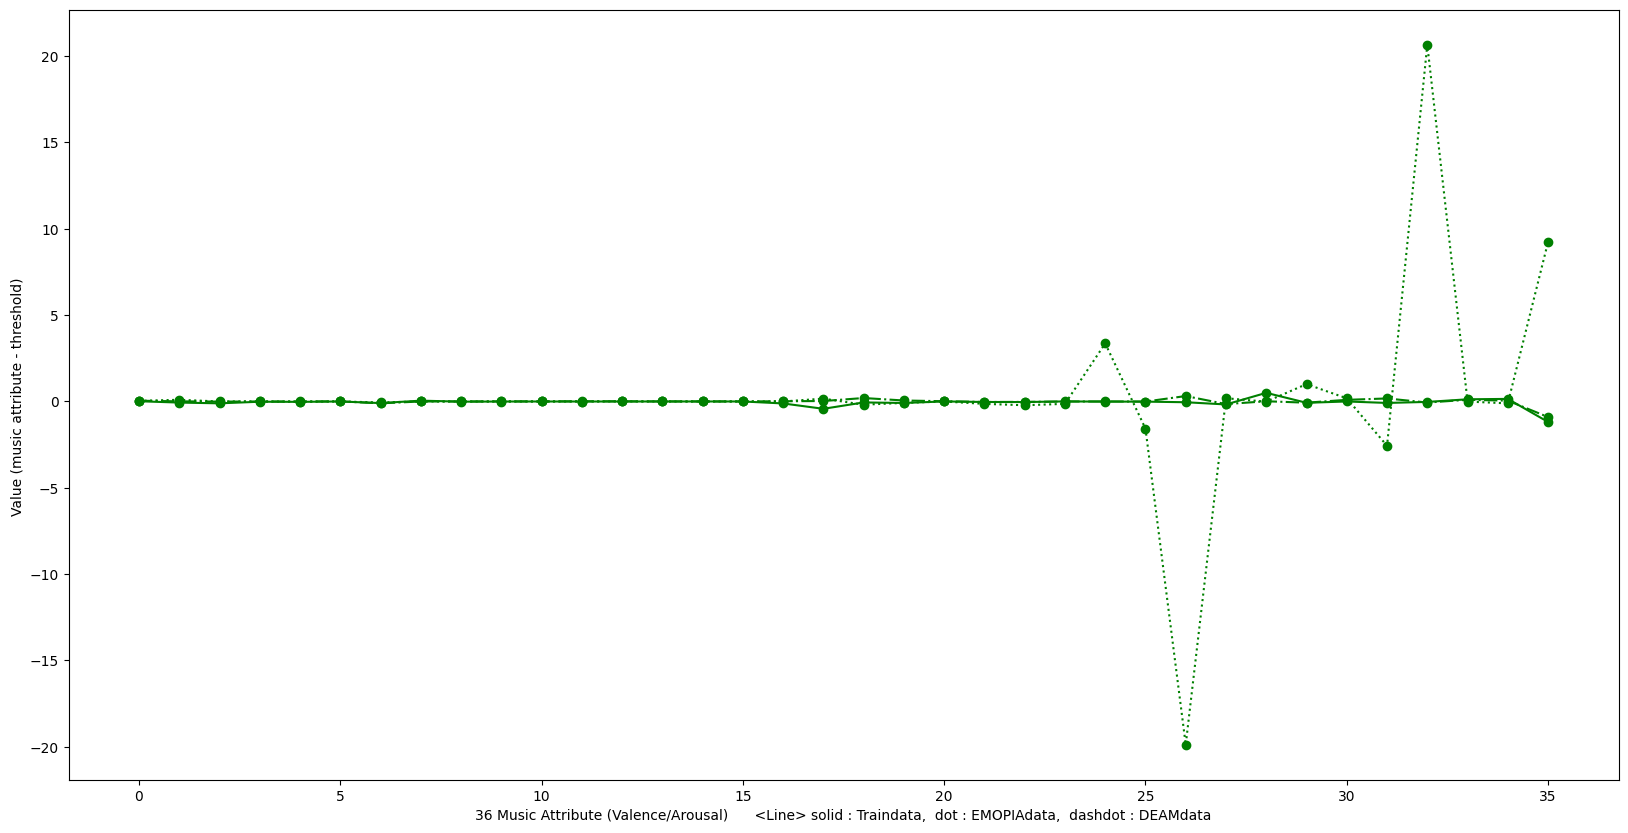

In [60]:
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(20,10))
plt.plot(real_train_18_noweight[0][number_a18_2], marker="o", color='green')  # marker="o",
plt.plot(np.squeeze(real_EMOPIA1_18_noweight)[number_a18_2],  marker="o", color='green', linestyle="dotted") #  ls="--",
plt.plot(np.squeeze(real_DEAM1_18_noweight)[number_a18_2],  marker="o", color='green', linestyle="dashdot")
plt.xlabel('36 Music Attribute (Valence/Arousal)      <Line> solid : Traindata,  dot : EMOPIAdata,  dashdot : DEAMdata')
plt.ylabel('Value (music attribute - threshold) ')
plt.show()


2. 重み(音楽属性値をtrainに揃える)付加したバージョン

In [ ]:
# データの読み込み
# 入力：18*2_重みなし

# trainデータ
real_train = np.load('traindata_attributeQ1_4.npy') # Q1:0  Q2:1  Q3:6  Q4:15
print(real_train[0].shape) #(24, 100)
real_train_18_weight = real_train * thresholds_weight0_100[0,:].float().unsqueeze(dim=1).T.numpy() * thresholds_weight_18_2 * real_mask18_2  ### 入力4. 18*2_重みなし


# EMOPIA
real_EMOPIA  = th.load('input_emotion_18_2_EMOPIA.pt').to('cpu').detach().numpy().copy()
real_EMOPIA1 = real_EMOPIA[0,:]
real_EMOPIA2 = real_EMOPIA[1,:]
real_EMOPIA3 = real_EMOPIA[2,:]
real_EMOPIA4 = real_EMOPIA[3,:]
russell_EMOPIA_weight = np.load('russell_train_weight.npz')['arr_0']
# 入力2-1：18_重みあり（閾値処理）＋trainに揃える
real_EMOPIA1_18_weight = (real_EMOPIA1 - thresholds)  * thresholds_weight_18_2 * mask18_2 * russell_EMOPIA_weight
real_EMOPIA2_18_weight = (real_EMOPIA2 - thresholds)  * thresholds_weight_18_2 * mask18_2 * russell_EMOPIA_weight
real_EMOPIA3_18_weight = (real_EMOPIA3 - thresholds)  * thresholds_weight_18_2 * mask18_2 * russell_EMOPIA_weight
real_EMOPIA4_18_weight = (real_EMOPIA4 - thresholds)  * thresholds_weight_18_2 * mask18_2 * russell_EMOPIA_weight
# 入力2-2：18_重みあり（閾値処理)
real_EMOPIA1_18_weight_2 = (real_EMOPIA1 - thresholds)  * thresholds_weight_18_2 * mask18_2 
real_EMOPIA2_18_weight_2 = (real_EMOPIA2 - thresholds)  * thresholds_weight_18_2 * mask18_2 
real_EMOPIA3_18_weight_2 = (real_EMOPIA3 - thresholds)  * thresholds_weight_18_2 * mask18_2 
real_EMOPIA4_18_weight_2 = (real_EMOPIA4 - thresholds)  * thresholds_weight_18_2 * mask18_2 
# 入力2-3：trainに揃える
real_EMOPIA1_18_weight_3 = (real_EMOPIA1 - thresholds)  * mask18_2 * russell_EMOPIA_weight
real_EMOPIA2_18_weight_3 = (real_EMOPIA2 - thresholds)  * mask18_2 * russell_EMOPIA_weight
real_EMOPIA3_18_weight_3 = (real_EMOPIA3 - thresholds)  * mask18_2 * russell_EMOPIA_weight
real_EMOPIA4_18_weight_3 = (real_EMOPIA4 - thresholds)  * mask18_2 * russell_EMOPIA_weight

# DEAM
real_DEAM  = th.load('input_emotion_18_2_DEAM.pt').to('cpu').detach().numpy().copy()
real_DEAM1 = real_DEAM[0,:]
real_DEAM2 = real_DEAM[1,:]
real_DEAM3 = real_DEAM[2,:]
real_DEAM4 = real_DEAM[3,:]
russell_DEAM_weight = np.load('DEAM_train_weight.npz')['arr_0']
# 入力2-1：18_重みあり（閾値処理）＋trainに揃える
real_DEAM1_18_weight = (real_DEAM1 - thresholds) * thresholds_weight_18_2 * mask18_2 * russell_DEAM_weight
real_DEAM2_18_weight = (real_DEAM2 - thresholds) * thresholds_weight_18_2 * mask18_2 * russell_DEAM_weight
real_DEAM3_18_weight = (real_DEAM3 - thresholds) * thresholds_weight_18_2 * mask18_2 * russell_DEAM_weight
real_DEAM4_18_weight = (real_DEAM4 - thresholds) * thresholds_weight_18_2 * mask18_2 * russell_DEAM_weight
# 入力2-2：18_重みあり（閾値処理）
real_DEAM1_18_weight_2 = (real_DEAM1 - thresholds) * thresholds_weight_18_2 * mask18_2 
real_DEAM2_18_weight_2 = (real_DEAM2 - thresholds) * thresholds_weight_18_2 * mask18_2 
real_DEAM3_18_weight_2 = (real_DEAM3 - thresholds) * thresholds_weight_18_2 * mask18_2 
real_DEAM4_18_weight_2 = (real_DEAM4 - thresholds) * thresholds_weight_18_2 * mask18_2 
# 入力2-3：trainに揃える
real_DEAM1_18_weight_3 = (real_DEAM1 - thresholds) * mask18_2 * russell_DEAM_weight
real_DEAM2_18_weight_3 = (real_DEAM2 - thresholds) * mask18_2 * russell_DEAM_weight
real_DEAM3_18_weight_3 = (real_DEAM3 - thresholds) * mask18_2 * russell_DEAM_weight
real_DEAM4_18_weight_3 = (real_DEAM4 - thresholds) * mask18_2 * russell_DEAM_weight



(100,)


In [80]:
print(russell_EMOPIA_weight[number_a18_2])
print(russell_DEAM_weight[number_a18_2])
print(thresholds_weight_18_2[:,number_a18_2])

[ 6.68160039e-01 -1.53235438e+00  2.44090730e-01 -5.65402576e-01
  6.18427167e-01  5.85890839e+00 -3.91356375e-01 -3.32983537e-02
  2.18450073e-01  4.64618546e-01  7.14841541e-01  1.11434925e+00
 -2.64525878e+00  2.23814424e-01  3.00043111e+00  7.27656473e-01
 -5.54607030e-01 -2.13452071e+00 -2.43799810e+00  1.59043589e+00
 -1.29105805e+00 -6.52780029e-01 -6.76294513e-01 -6.46940951e-02
  5.45507481e-02 -3.15334856e-01 -6.63055845e+00 -5.50199984e-01
  9.94609224e-03 -1.34052888e+01  1.60880040e+00 -1.84255408e+00
  9.70040448e-01  1.30377778e+00  7.76101857e-01 -8.32334036e-01]
[ 7.68338556e-01  1.14876237e+00  3.53356573e-01  1.83303679e+00
  1.26348944e+00  4.39180931e-01  4.97319237e-01  1.68748143e-02
  2.51095919e-01  2.21721408e-01  4.24609522e-01  4.00283211e-01
  3.47174301e-01  2.86483953e-01  5.85831343e-01  2.32933300e-01
 -2.09044440e-01  1.01744729e+00 -9.59377431e+00 -6.49476621e-01
 -1.20058271e-01  3.49033512e-01  4.16802755e-01  1.47006781e-01
 -2.60303779e-01  5.2716

* 重みあり　& 重みなし

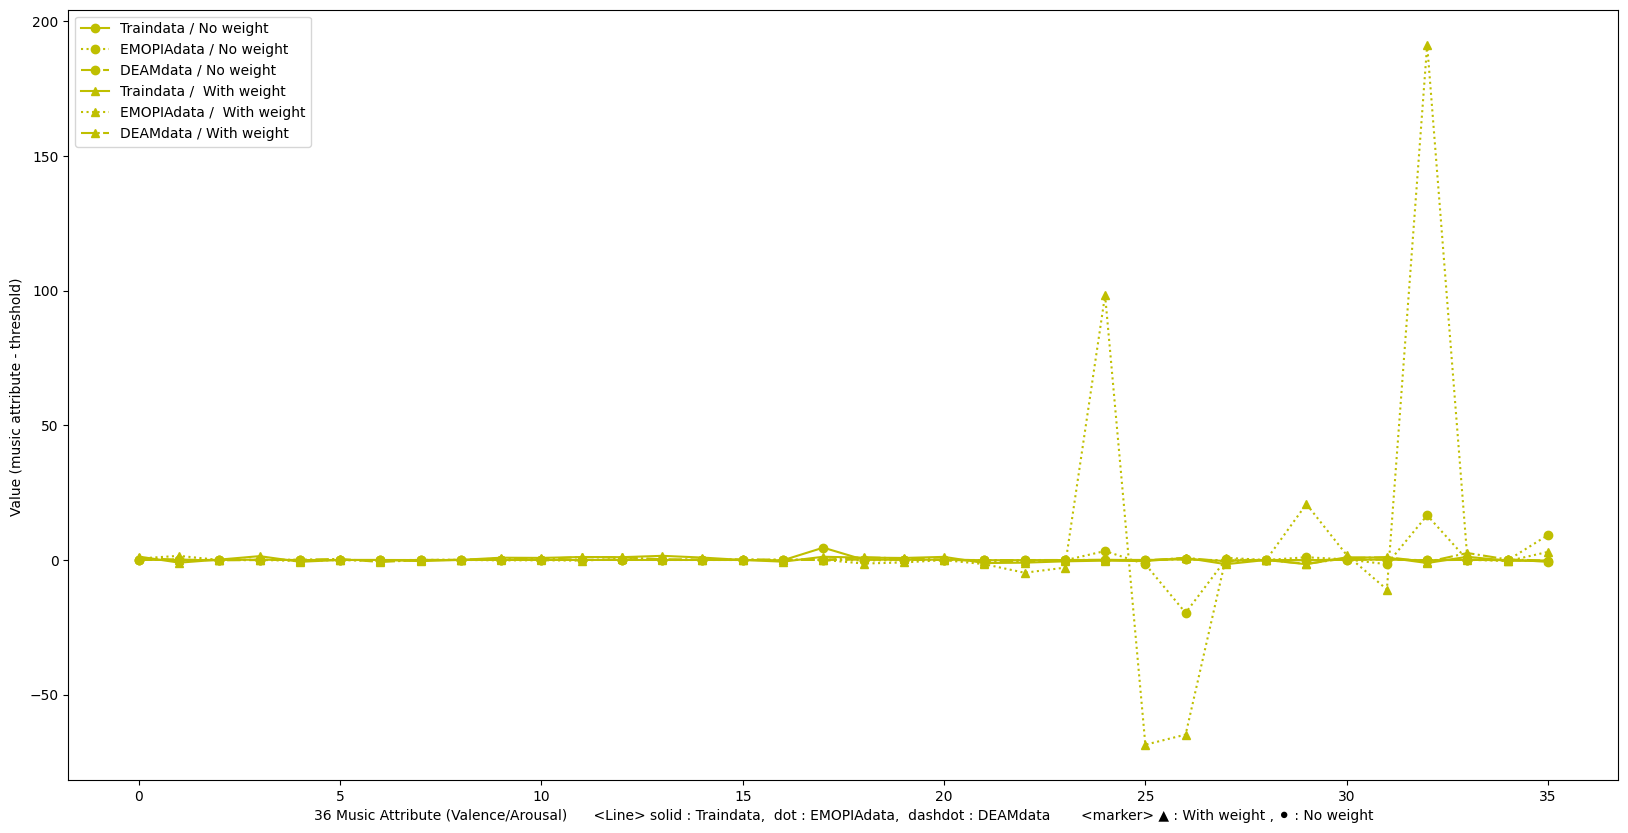

In [73]:
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(20,10))
plt.plot(real_train_18_noweight[15][number_a18_2],marker="o" ,color='y',label="Traindata / No weight")  # marker="o",
plt.plot(np.squeeze(real_EMOPIA4_18_noweight)[number_a18_2],  marker="o", color='y', linestyle="dotted",label="EMOPIAdata / No weight") #  ls="--",
plt.plot(np.squeeze(real_DEAM4_18_noweight)[number_a18_2],  marker="o", color='y', linestyle="dashdot",label="DEAMdata / No weight")
plt.plot(real_train_18_weight[15][number_a18_2], marker="^", color='y',label="Traindata /  With weight")  # marker="o",
plt.plot(np.squeeze(real_EMOPIA4_18_weight)[number_a18_2],  marker="^", color='y', linestyle="dotted",label="EMOPIAdata /  With weight") #  ls="--",
plt.plot(np.squeeze(real_DEAM4_18_weight)[number_a18_2],  marker="^", color='y', linestyle="dashdot",label="DEAMdata / With weight")
plt.xlabel('36 Music Attribute (Valence/Arousal)      <Line> solid : Traindata,  dot : EMOPIAdata,  dashdot : DEAMdata       <marker> ▲ : With weight , ⚫︎ : No weight')
plt.ylabel('Value (music attribute - threshold) ')
plt.legend() #凡例
plt.show()

* EMOPIAについての図 (4種類プロット)

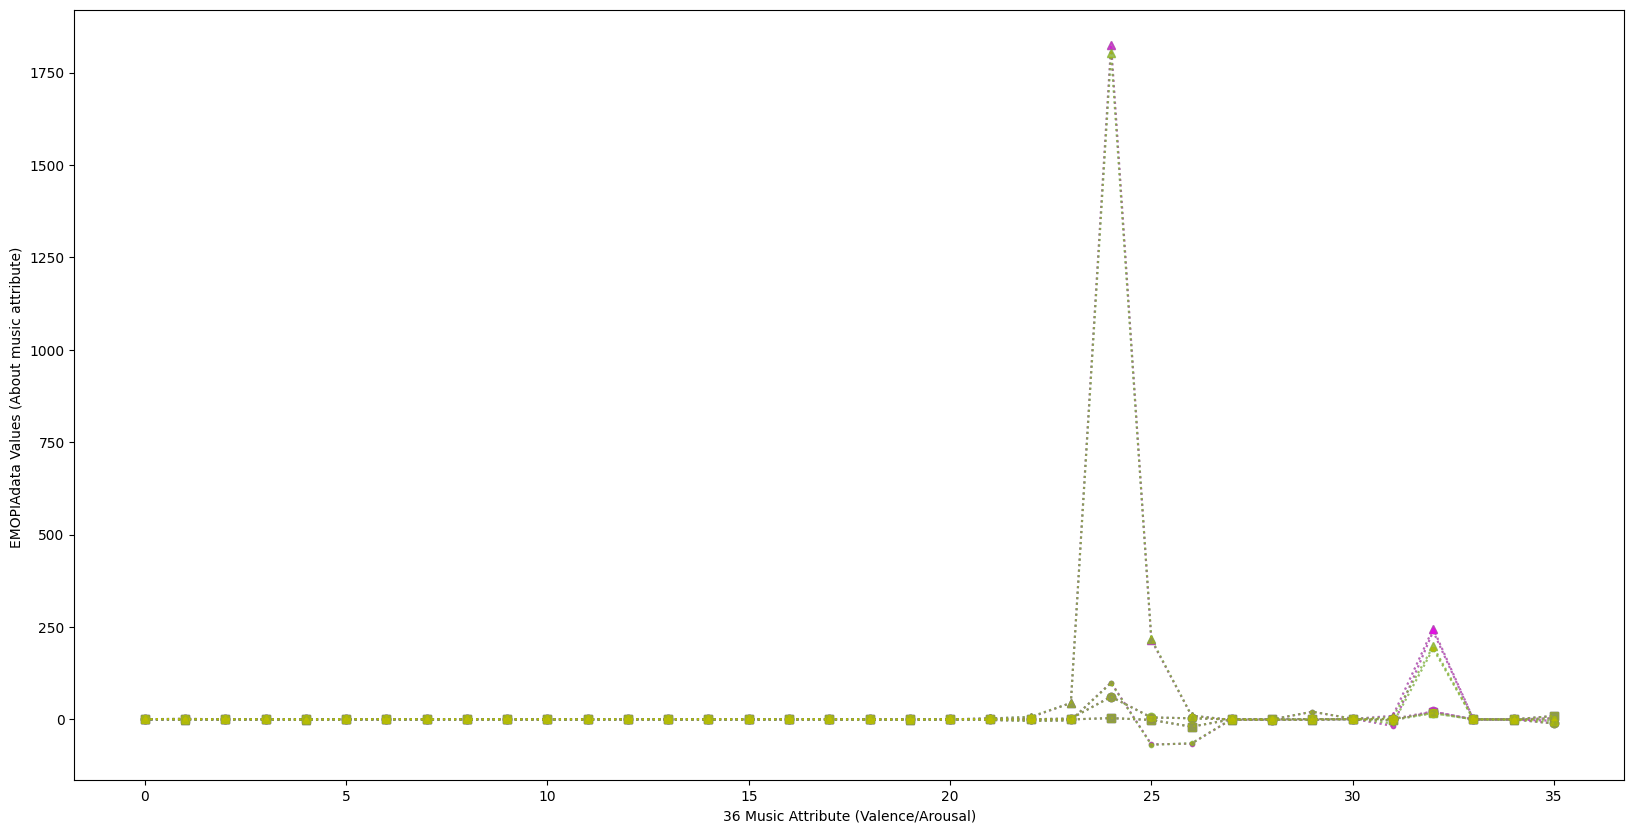

In [52]:
# EMOPIAについて
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(20,10))
# Q1
plt.plot(np.squeeze(real_EMOPIA1_18_noweight)[number_a18_2],  marker="o", color='green', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA1_18_weight)[number_a18_2],  marker=".", color='green', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA1_18_weight_2)[number_a18_2],  marker="^", color='green', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA1_18_weight_3)[number_a18_2],  marker="s", color='green', linestyle="dotted" , alpha=0.5) #  ls="--",
# Q2
plt.plot(np.squeeze(real_EMOPIA2_18_noweight)[number_a18_2],  marker="o", color='magenta', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA2_18_weight)[number_a18_2],  marker=".", color='magenta', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA2_18_weight_2)[number_a18_2],  marker="^", color='magenta', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA2_18_weight_3)[number_a18_2],  marker="s", color='magenta', linestyle="dotted" , alpha=0.5) #  ls="--",
# Q3
plt.plot(np.squeeze(real_EMOPIA3_18_noweight)[number_a18_2],  marker="o", color='darkcyan', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA3_18_weight)[number_a18_2],  marker=".", color='darkcyan', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA3_18_weight_2)[number_a18_2],  marker="^", color='darkcyan', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA3_18_weight_3)[number_a18_2],  marker="s", color='darkcyan', linestyle="dotted" , alpha=0.5) #  ls="--",
# Q4
plt.plot(np.squeeze(real_EMOPIA4_18_noweight)[number_a18_2],  marker="o", color='y', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA4_18_weight)[number_a18_2],  marker=".", color='y', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA4_18_weight_2)[number_a18_2],  marker="^", color='y', linestyle="dotted" , alpha=0.5)
plt.plot(np.squeeze(real_EMOPIA4_18_weight_3)[number_a18_2],  marker="s", color='y', linestyle="dotted" , alpha=0.5) #  ls="--",
plt.xlabel('36 Music Attribute (Valence/Arousal)')
plt.ylabel('EMOPIAdata Values (About music attribute) ')
plt.show()

* DEAMについての図

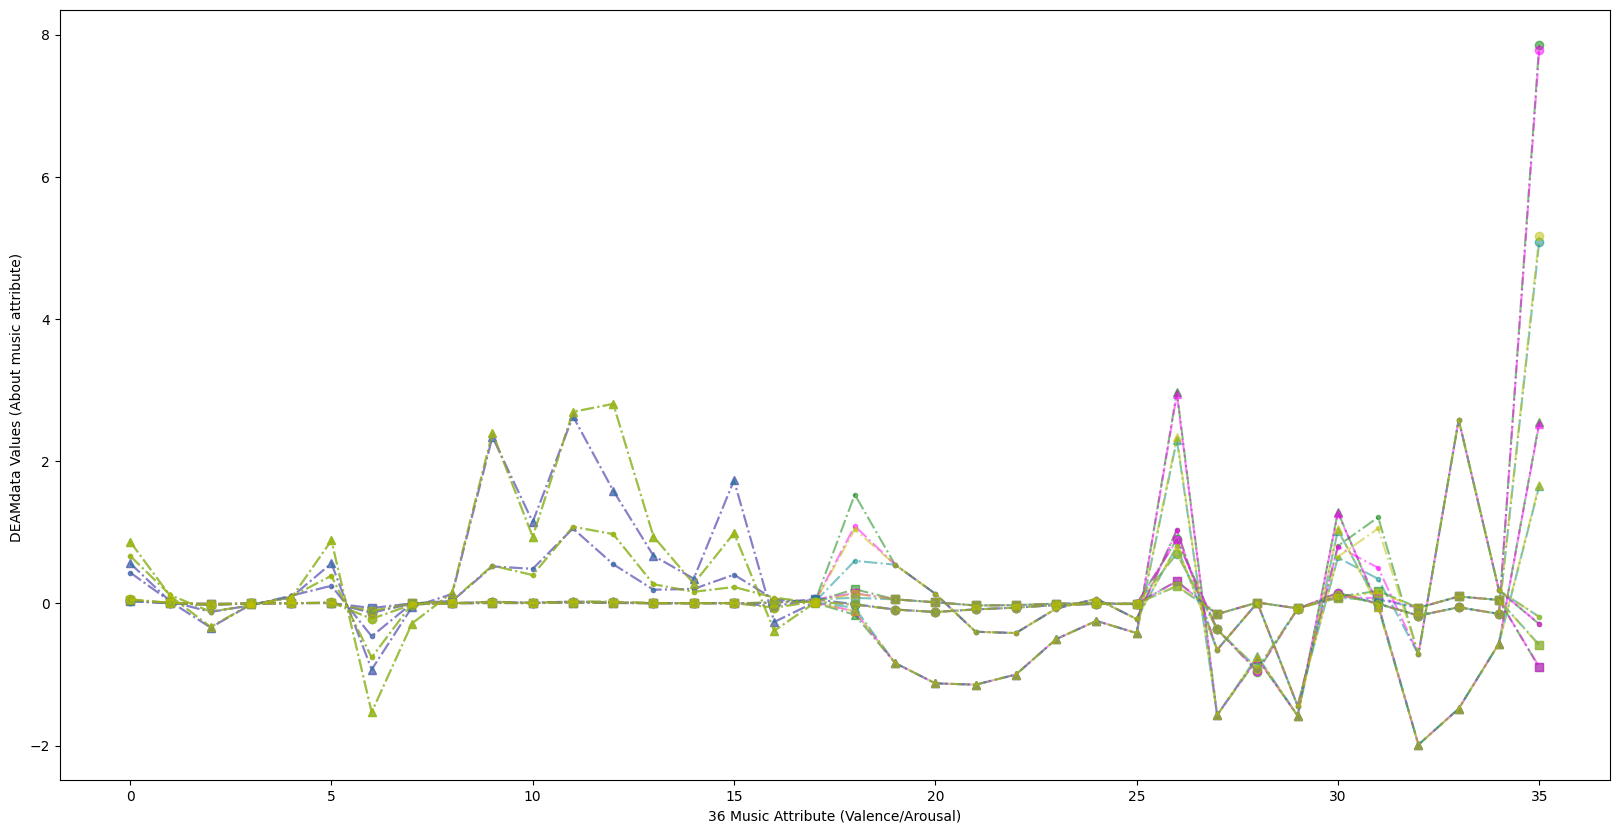

In [51]:
# EMOPIAについて
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(20,10))
# Q1
plt.plot(np.squeeze(real_DEAM1_18_noweight)[number_a18_2],  marker="o", color='green', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM1_18_weight)[number_a18_2],  marker=".", color='green', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM1_18_weight_2)[number_a18_2],  marker="^", color='green', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM1_18_weight_3)[number_a18_2],  marker="s", color='green', linestyle="dashdot" , alpha=0.5) #  ls="--",
# Q2
plt.plot(np.squeeze(real_DEAM2_18_noweight)[number_a18_2],  marker="o", color='magenta', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM2_18_weight)[number_a18_2],  marker=".", color='magenta', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM2_18_weight_2)[number_a18_2],  marker="^", color='magenta', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM2_18_weight_3)[number_a18_2],  marker="s", color='magenta', linestyle="dashdot" , alpha=0.5) #  ls="--",
# Q3
plt.plot(np.squeeze(real_DEAM3_18_noweight)[number_a18_2],  marker="o", color='darkcyan', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM3_18_weight)[number_a18_2],  marker=".", color='darkcyan', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM3_18_weight_2)[number_a18_2],  marker="^", color='darkcyan', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM3_18_weight_3)[number_a18_2],  marker="s", color='darkcyan', linestyle="dashdot" , alpha=0.5) #  ls="--",
# Q4
plt.plot(np.squeeze(real_DEAM4_18_noweight)[number_a18_2],  marker="o", color='y', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM4_18_weight)[number_a18_2],  marker=".", color='y', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM4_18_weight_2)[number_a18_2],  marker="^", color='y', linestyle="dashdot" , alpha=0.5)
plt.plot(np.squeeze(real_DEAM4_18_weight_3)[number_a18_2],  marker="s", color='y', linestyle="dashdot" , alpha=0.5) #  ls="--",
plt.xlabel('36 Music Attribute (Valence/Arousal)')
plt.ylabel('DEAMdata Values (About music attribute) ')
plt.show()

### 出力間(生成音楽間)の音楽属性値の類似
Train , EMOPIA ,  DEAM

In [35]:
import numpy as np
import pandas as pd
import torch as th

thresholds = np.squeeze(np.load("../../../../../../data/threshold.npy", allow_pickle=True)) #閾値
feature_index = np.load("../../../../../../data/feature_index.npy", allow_pickle=True) #特徴量100

# Trainデータによる生成音楽
train_result_attribute_csv_1 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/traindata_attribute/18_2_weight_guidance1_2_Q1.csv',usecols=feature_index+1) #skiprows=1)
train_result_attribute_csv_2 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/traindata_attribute/18_2_weight_guidance1_2_Q2.csv',usecols=feature_index+1) #skiprows=1)
train_result_attribute_csv_3 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/traindata_attribute/18_2_weight_guidance1_2_Q3.csv',usecols=feature_index+1) #skiprows=1)
train_result_attribute_csv_4 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/traindata_attribute/18_2_weight_guidance1_2_Q4.csv',usecols=feature_index+1) #skiprows=1)
train_result_attribute_1 = np.zeros((0,100))
train_result_attribute_2 = np.zeros((0,100))
train_result_attribute_3 = np.zeros((0,100))
train_result_attribute_4 = np.zeros((0,100))
for j in range(8):
    r_a_0_1 = np.squeeze(np.array(train_result_attribute_csv_1[j:j+1].values))
    r_a__1 = [np.float64(r_a_00_1) for r_a_00_1 in r_a_0_1]
    train_result_attribute_1 = np.append(train_result_attribute_1, (r_a__1 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_2 = np.squeeze(np.array(train_result_attribute_csv_2[j:j+1].values))
    r_a__2 = [np.float64(r_a_00_2) for r_a_00_2 in r_a_0_2]
    train_result_attribute_2 = np.append(train_result_attribute_2, (r_a__2 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_3 = np.squeeze(np.array(train_result_attribute_csv_3[j:j+1].values))
    r_a__3 = [np.float64(r_a_00_3) for r_a_00_3 in r_a_0_3]
    train_result_attribute_3 = np.append(train_result_attribute_3, (r_a__3 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_4 = np.squeeze(np.array(train_result_attribute_csv_4[j:j+1].values))
    r_a__4 = [np.float64(r_a_00_4) for r_a_00_4 in r_a_0_4]
    train_result_attribute_4 = np.append(train_result_attribute_4, (r_a__4 - thresholds)) #*thresholds_weight_100) # ① 100   
threshold_train_all_1 = train_result_attribute_1.reshape(8,100)
threshold_train_all_2 = train_result_attribute_2.reshape(8,100)
threshold_train_all_3 = train_result_attribute_3.reshape(8,100)
threshold_train_all_4 = train_result_attribute_4.reshape(8,100)

# EMOPIAモデルによる生成音楽
EMOPIA_result_attribute_csv_1 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CG_18*2/attribute/EMOPIAdata_attribute/Q1_CG_50_18*2_weight.csv',usecols=feature_index+1) #skiprows=1)
EMOPIA_result_attribute_csv_2 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CG_18*2/attribute/EMOPIAdata_attribute/Q2_CG_50_18*2_weight.csv',usecols=feature_index+1) #skiprows=1)
EMOPIA_result_attribute_csv_3 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CG_18*2/attribute/EMOPIAdata_attribute/Q3_CG_50_18*2_weight.csv',usecols=feature_index+1) #skiprows=1)
EMOPIA_result_attribute_csv_4 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CG_18*2/attribute/EMOPIAdata_attribute/Q4_CG_50_18*2_weight.csv',usecols=feature_index+1) #skiprows=1)
EMOPIA_result_attribute_1 = np.zeros((0,100))
EMOPIA_result_attribute_2 = np.zeros((0,100))
EMOPIA_result_attribute_3 = np.zeros((0,100))
EMOPIA_result_attribute_4 = np.zeros((0,100))
for j in range(8):
    r_a_0_1 = np.squeeze(np.array(EMOPIA_result_attribute_csv_1[j:j+1].values))
    r_a__1 = [np.float64(r_a_00_1) for r_a_00_1 in r_a_0_1]
    EMOPIA_result_attribute_1 = np.append(EMOPIA_result_attribute_1, (r_a__1 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_2 = np.squeeze(np.array(EMOPIA_result_attribute_csv_2[j:j+1].values))
    r_a__2 = [np.float64(r_a_00_2) for r_a_00_2 in r_a_0_2]
    EMOPIA_result_attribute_2 = np.append(EMOPIA_result_attribute_2, (r_a__2 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_3 = np.squeeze(np.array(EMOPIA_result_attribute_csv_3[j:j+1].values))
    r_a__3 = [np.float64(r_a_00_3) for r_a_00_3 in r_a_0_3]
    EMOPIA_result_attribute_3 = np.append(EMOPIA_result_attribute_3, (r_a__3 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_4 = np.squeeze(np.array(EMOPIA_result_attribute_csv_4[j:j+1].values))
    r_a__4 = [np.float64(r_a_00_4) for r_a_00_4 in r_a_0_4]
    EMOPIA_result_attribute_4 = np.append(EMOPIA_result_attribute_4, (r_a__4 - thresholds)) #*thresholds_weight_100) # ① 100   
threshold_EMOPIA_all_1 = EMOPIA_result_attribute_1.reshape(8,100)
threshold_EMOPIA_all_2 = EMOPIA_result_attribute_2.reshape(8,100)
threshold_EMOPIA_all_3 = EMOPIA_result_attribute_3.reshape(8,100)
threshold_EMOPIA_all_4 = EMOPIA_result_attribute_4.reshape(8,100)


# DEAMデータによる生成音楽
DEAM_result_attribute_csv_1 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/DEAM_attribute/18_2_weight_guidance1_2_Q1.csv',usecols=feature_index+1) #skiprows=1)
DEAM_result_attribute_csv_2 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/DEAM_attribute/18_2_weight_guidance1_2_Q2.csv',usecols=feature_index+1) #skiprows=1)
DEAM_result_attribute_csv_3 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/DEAM_attribute/18_2_weight_guidance1_2_Q3.csv',usecols=feature_index+1) #skiprows=1)
DEAM_result_attribute_csv_4 = pd.read_csv('/Users/kawabemoyu/Desktop/修論関連/CFG_18*2/attribute/DEAM_attribute/18_2_weight_guidance1_2_Q4.csv',usecols=feature_index+1) #skiprows=1)
DEAM_result_attribute_1 = np.zeros((0,100))
DEAM_result_attribute_2 = np.zeros((0,100))
DEAM_result_attribute_3 = np.zeros((0,100))
DEAM_result_attribute_4 = np.zeros((0,100))
for j in range(8):
    r_a_0_1 = np.squeeze(np.array(DEAM_result_attribute_csv_1[j:j+1].values))
    r_a__1 = [np.float64(r_a_00_1) for r_a_00_1 in r_a_0_1]
    DEAM_result_attribute_1 = np.append(DEAM_result_attribute_1, (r_a__1 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_2 = np.squeeze(np.array(DEAM_result_attribute_csv_2[j:j+1].values))
    r_a__2 = [np.float64(r_a_00_2) for r_a_00_2 in r_a_0_2]
    DEAM_result_attribute_2 = np.append(DEAM_result_attribute_2, (r_a__2 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_3 = np.squeeze(np.array(DEAM_result_attribute_csv_3[j:j+1].values))
    r_a__3 = [np.float64(r_a_00_3) for r_a_00_3 in r_a_0_3]
    DEAM_result_attribute_3 = np.append(DEAM_result_attribute_3, (r_a__3 - thresholds)) #*thresholds_weight_100) # ① 100
    r_a_0_4 = np.squeeze(np.array(DEAM_result_attribute_csv_4[j:j+1].values))
    r_a__4 = [np.float64(r_a_00_4) for r_a_00_4 in r_a_0_4]
    DEAM_result_attribute_4 = np.append(DEAM_result_attribute_4, (r_a__4 - thresholds)) #*thresholds_weight_100) # ① 100   
threshold_DEAM_all_1 = DEAM_result_attribute_1.reshape(8,100)
threshold_DEAM_all_2 = DEAM_result_attribute_2.reshape(8,100)
threshold_DEAM_all_3 = DEAM_result_attribute_3.reshape(8,100)
threshold_DEAM_all_4 = DEAM_result_attribute_4.reshape(8,100)

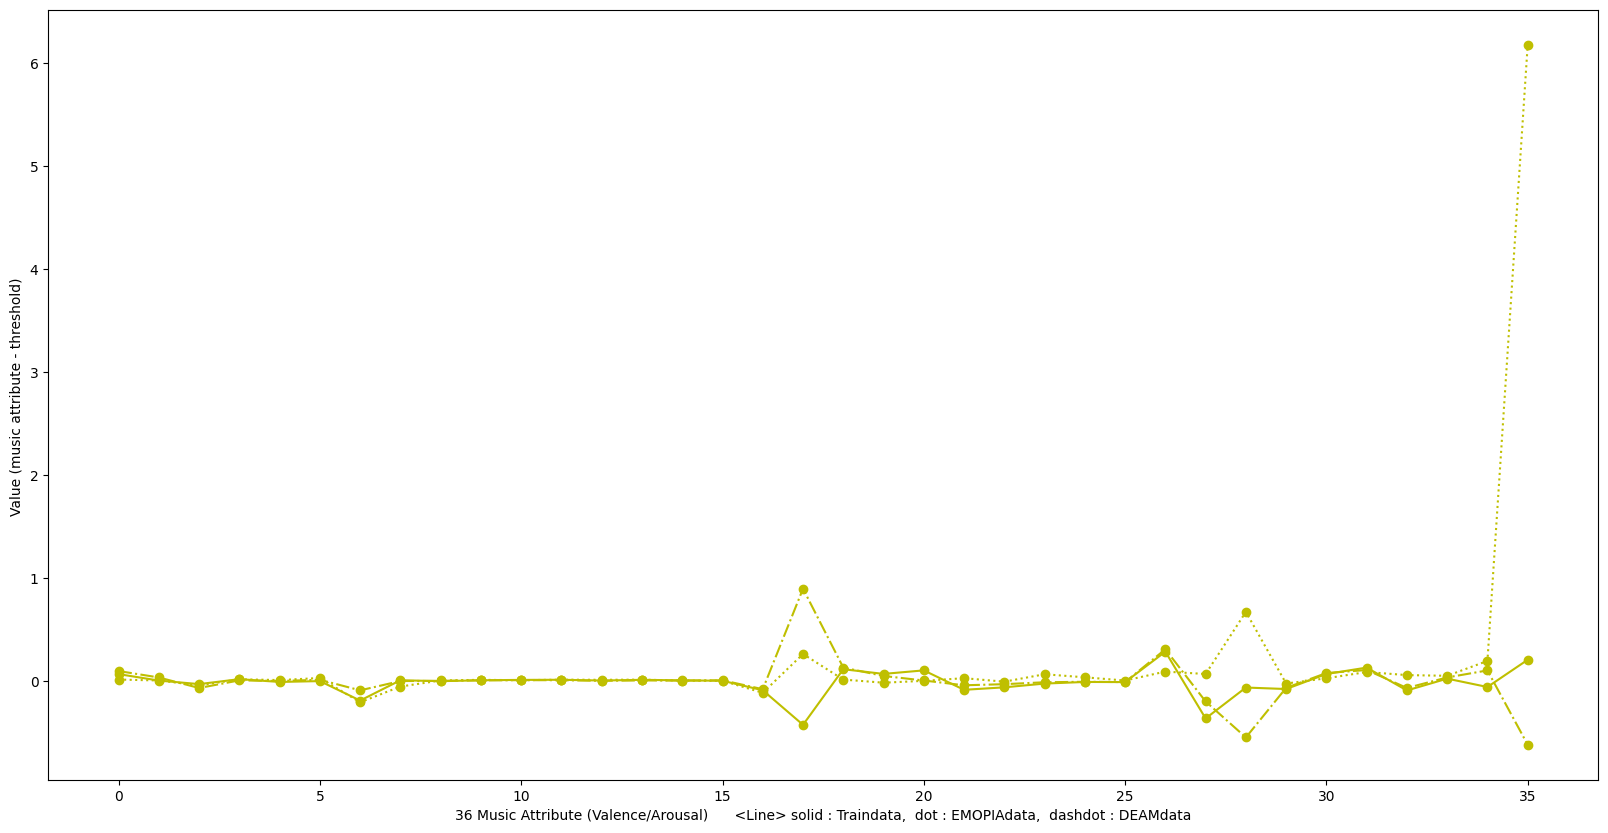

In [44]:
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(20,10))
plt.plot(np.mean(threshold_train_all_4,0)[number_a18_2], marker="o", color='y')  # marker="o",
plt.plot(np.mean(threshold_EMOPIA_all_4,0)[number_a18_2],  marker="o", color='y', linestyle="dotted") #  ls="--",
plt.plot(np.mean(threshold_DEAM_all_4,0)[number_a18_2],  marker="o", color='y', linestyle="dashdot")
plt.xlabel('36 Music Attribute (Valence/Arousal)      <Line> solid : Traindata,  dot : EMOPIAdata,  dashdot : DEAMdata')
plt.ylabel('Value (music attribute - threshold) ')
plt.show()


### 入力値の大きさ  

--- 入力モデルが予測する音楽属性値の大きさ ---
* Russell **real_train1**   

--- 学習データに対応する音楽属性値の大きさ---  
* trainデータ  **real_train[1]** 　

In [45]:
import torch.nn.functional as F
import numpy as np
import torch as th

print("DEAM data")
print(np.linalg.norm(np.squeeze(real_train1)))
print("DEAM data norm")
print(np.linalg.norm(F.normalize(th.from_numpy(np.squeeze(real_train1)), p=2, dim=0).numpy()))

'''
print("EMOPIA data")
print(np.linalg.norm(np.squeeze(real_train1)))
print("Russell data norm")
print(np.linalg.norm(F.normalize(th.from_numpy(np.squeeze(real_train1)), p=2, dim=0).numpy()))

print("train data")
print(np.linalg.norm(np.squeeze(real_train[1])))
print("train data norm")
print(np.linalg.norm(F.normalize(th.from_numpy(np.squeeze(real_train[1])), p=2, dim=0).numpy()))
'''

DEAM data
18.999651
DEAM data norm
1.0


'\nprint("EMOPIA data")\nprint(np.linalg.norm(np.squeeze(real_train1)))\nprint("Russell data norm")\nprint(np.linalg.norm(F.normalize(th.from_numpy(np.squeeze(real_train1)), p=2, dim=0).numpy()))\n\nprint("train data")\nprint(np.linalg.norm(np.squeeze(real_train[1])))\nprint("train data norm")\nprint(np.linalg.norm(F.normalize(th.from_numpy(np.squeeze(real_train[1])), p=2, dim=0).numpy()))\n'

***************************  
EMOPIA data (100)：326.9216715722795   
  
train data：35.43537416967806    
   
DEAM data (18_2)：18.999651    
***************************  

In [45]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

print(np.linalg.norm(np.squeeze(real_train2)))
print(np.linalg.norm(np.squeeze(real_train2_threshold)))
print("realdata")
# realdata
print(cos_sim(real_train1_threshold, real_train2_threshold))
print(cos_sim(real_train2_threshold, real_train3_threshold))
print(cos_sim(real_train3_threshold , real_train4_threshold))
print(cos_sim(real_train1_threshold , real_train4_threshold))
print(cos_sim(real_train3_threshold , real_train1_threshold))
print(cos_sim(real_train2_threshold , real_train4_threshold))

print("traindata")
# traindata
print(np.linalg.norm(real_train[1]))
print(np.linalg.norm(real_train[2]))
print(cos_sim(real_train[1] , real_train[0]))
print(cos_sim(real_train[1] , real_train[2]))
print(cos_sim(real_train[2] , real_train[3]))
print(cos_sim(real_train[3] , real_train[0]))
print(cos_sim(real_train[0] , real_train[2]))
print(cos_sim(real_train[1] , real_train[3]))

print("traindata")

print(cos_sim(real_train[0] ,real_train1_threshold))
print(cos_sim(real_train[1] ,real_train2_threshold))
print(cos_sim(real_train[2] ,real_train3_threshold))
print(cos_sim(real_train[3] ,real_train4_threshold))


358.61480374683487
33.37272314715534
realdata
0.9955256796584265
0.9845769956780736
0.9955995927653284
0.9846193611467996
0.9841881045573995
0.9761420071348627
traindata
35.43537416967806
34.44409502776098
0.92508657775686
0.9617872067318561
0.9478977748467698
0.9362963586617471
0.9232230953017744
0.9697168491855798
traindata
0.9455548084267161
0.9770458281344951
0.9713019493689063
0.9727780103157884


* 音楽属性値の100値の分布  (閾値処理済み)
1. 閾値：🟥    
2. trainデータ(Q1)(閾値処理済み)：🟢  
3. Russell_EMOPIAの座標のデータ(Q1)(閾値処理済み)：🟦 

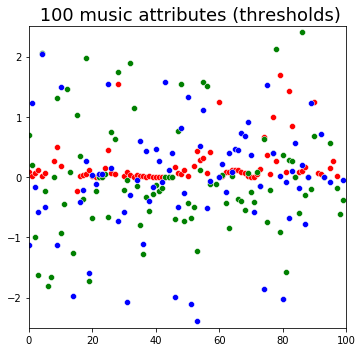

In [33]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sc = StandardScaler() 

thresholds = np.squeeze(np.load("../../../../../../data/threshold.npy", allow_pickle=True)) #閾値

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.title(" 100 music attributes (thresholds)", fontsize=18)
# 1. 閾値　(thresholds)
sns.scatterplot(data = thresholds, color="red")
# 2. 実際のTrainデータ　(閾値処理あり) (Q1)
sns.scatterplot(data = real_train[0], color="green")
# 3. Russell_EMOPIAの座標のデータ　(閾値処理あり) (Q1)
sns.scatterplot(data = real_train1_threshold , color="blue")

# (3)x軸の表示範囲
plt.xlim(0.0 , 100.0) 
# plt.ylim(-10.0 , 10.0) 
plt.ylim(-2.5 , 2.5) 
plt.tight_layout()
plt.show()

* 音楽属性値の100値の分布  (閾値処理❌)
1. 閾値：🟥    
2. trainデータ(Q1)(閾値処理済み)：🟢  
3. Russell_EMOPIAの座標のデータ(Q1)(閾値処理済み)：🟦 

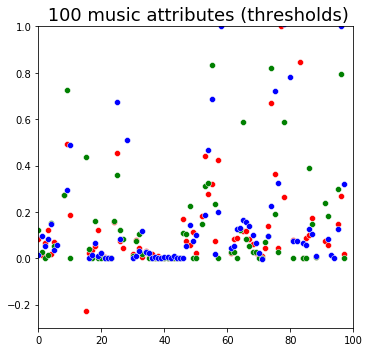

In [38]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sc = StandardScaler() 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.title(" 100 music attributes (thresholds)", fontsize=18)
# 1. 閾値　(thresholds)
sns.scatterplot(data = thresholds, color="red")
# 2. 実際のTrainデータ　(閾値処理 × ) (Q1)
real_train_0 = real_train[0]*thresholds_weight0[0,:].numpy() + thresholds
sns.scatterplot(data = real_train_0, color="green")
# 3. Russell_EMOPIAの座標のデータ　(閾値処理 × ) (Q1)
sns.scatterplot(data = np.squeeze(real_train1) , color="blue")


# (3)x軸の表示範囲
plt.xlim(0.0 , 100.0) 
#plt.ylim(-10.0 , 10.0) 
plt.ylim(-0.3 , 1.0) 
plt.tight_layout()
plt.show()

→ 元のデータの大きさの桁に、差はない  
→ 閾値からの差が異なる...?  
* trainデータ：マイナス100↑、Russellデータ：プラス200  
**↓↓↓ 2倍ぐらい差がありそう**

* 2つのデータの、閾値との**値の大きさの差**

In [43]:
print("threshold ")
print(np.linalg.norm(np.squeeze(thresholds)))
# 2
'''
print("train data")
print(np.linalg.norm(np.squeeze(real_train_0)))
print("--difference threshold ")
print(np.linalg.norm(np.squeeze(real_train_0) - np.squeeze(thresholds)))
# 3
print("Russell data")
print(np.linalg.norm(np.squeeze(real_train1)))
print("--difference threshold ")
print(np.linalg.norm((np.squeeze(real_train1) - np.squeeze(thresholds))))
'''
# 4 
print("DEAM data")
print(np.linalg.norm(np.squeeze(real_train1)))
print("--difference threshold ")
print(np.linalg.norm((np.squeeze(real_train1) - np.squeeze(thresholds))))


threshold 
256.27042918674346
DEAM data
18.999651
--difference threshold 
256.15093652351186


threshold   
256.27042918674346  
train data  
121.64358038728408  
--difference threshold  
159.9367627302866  
EMOPIA (100) data  
326.9216715722795  
--difference threshold   
407.55972464646067  
DEAM data  
18.999651  
--difference threshold   
256.15093652351186  

2. 実際のTrainデータ 🟢  
3. Russell_EMOPIAの座標のデータ 🟦  ：差は3倍↑
* 閾値処理 ×   
* Q1

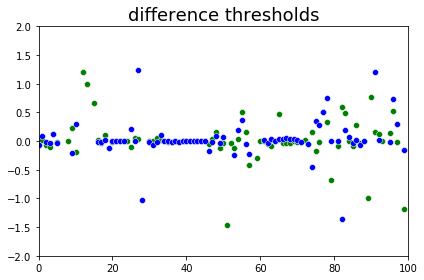

In [44]:
plt.title("difference thresholds", fontsize=18)
# 2. 実際のTrainデータ(閾値処理 × ) (Q1)
real_train_0 = real_train[0]*thresholds_weight0[0,:].numpy() + thresholds
data1_train = np.squeeze(real_train_0) - np.squeeze(thresholds)
sns.scatterplot(data = data1_train, color="green")
# 3. Russell_EMOPIAの座標のデータ　(閾値処理 × ) (Q1)
data1_Russell = np.squeeze(real_train1) - np.squeeze(thresholds)
sns.scatterplot(data = data1_Russell , color="blue")

plt.xlim(0.0 , 100.0) 
#plt.ylim(-10.0 , 10.0) 
plt.ylim(-2.0 , 2.0) 
plt.tight_layout()
plt.show()

### 2種類のデータの、「閾値からの差」の値の平均

In [11]:
import torch.nn.functional as F
import numpy as np
import torch as th
thresholds = np.load("../../../../../../data/threshold.npy", allow_pickle=True) #閾値
feature_index = np.load("../../../../../../data/feature_index.npy", allow_pickle=True) #特徴量100
thresholds_weight0 = th.load('./std_mean.pt') # 音楽属性値を揃える重み
thresholds_weight = th.where(thresholds_weight0[0,:] == 0.0, (th.tensor(0.0).float()), ((1.0 / thresholds_weight0[0,:]).float())).to('cpu').detach().numpy().copy() 

1. 閾値処理なしのデータを用意   
* all_train_data # 2  
* all_russell_data # 3  

In [15]:
import numpy as np
import pandas as pd
import ast
import os

# 2.trainデータ　(100つの属性値・閾値処理×)
all_train_data0 = np.load('./attribute100_threshold_train_CFG.npz') # 閾値処理⭕️
all_train_data_nothresholds = all_train_data0['arr_0'] # (212967,100)
all_train_data = []
for k2 ,t_k2 in enumerate(all_train_data_nothresholds):
    binary_command = all_train_data_nothresholds[k2,:]*thresholds_weight0[0,:].numpy() + thresholds.T # 閾値処理×にする
    all_train_data.append(np.squeeze(binary_command)) # ←↑ そのままだと(212967, 100, 100)になってしまう
all_train_data = np.squeeze(np.array(all_train_data))
print(all_train_data.shape)


# 3. EMOPIAデータ (100つの属性値・閾値処理×)
all_russell_data00 = pd.read_csv('../xydata_attribute.csv') # emotion_ar_va.ipynb
t0 = np.array(all_russell_data00['Attribute'].values)
all_russell_data0 = np.zeros((0,1496))
for tt in t0:
   tt = np.array(ast.literal_eval(tt)) # 文字列 → リスト・辞書型変換
   all_russell_data0 = np.append(all_russell_data0,tt)
all_russell_data0 = all_russell_data0.reshape(1071, 1496)
#音楽属性値の0,1の値を決める関数
def binarize_command(command, thresholds):
        discrete_feature = []
        discrete_feature.append(command) 
        return discrete_feature
all_EMOPIA_data = []
for k3 ,t_k3 in enumerate(all_russell_data0):
    binary_command = binarize_command(all_russell_data0[k3][feature_index], thresholds)
    all_EMOPIA_data.append(binary_command)
all_EMOPIA_data = np.squeeze(np.array(all_EMOPIA_data))
print(all_EMOPIA_data.shape)


# 4.DEAMデータ
df = pd.read_csv("../dataset/DEAM_annotations/attribute_combined.csv")
df_midiname = []
df_attribute = np.zeros((0,1495))#,100)
for i in range(len(df['0'].values)):
    #print(df['0'].values[i][-8:-4]) 
    df1 = df['0'].values[i].split('/')  # ディレクトリごとに区切る # np.genfromtxt：複雑なファイルの読み込み
    df1 = df1[-1].split('.') # 番号と'mid'を区切る
    df_midiname.append(int(df1[0])) # sortできるように、整数変換
    df2 = df.iloc[i,1:].values # iloc：行、列番号を指定
    df_attribute = np.append(df_attribute , np.array(df2))#,axis=0)    
# midi番号
df_VA = pd.read_csv("../dataset/DEAM_annotations/VA_combined.csv") #, usecols=[' valence_mean', ' arousal_mean'])
df_midiname0 = df_VA['song_id'].values 
df_midiname  
# midi属性値
df_attribute = np.reshape(df_attribute , [len(df['0'].values), 1495]) # np.reshape：形状変形
# arrtibute 昇順
attribute = np.zeros((len(df_midiname),1495)) 
k = 0
j = 0
for j, number in enumerate(df_midiname): # [1999, 1769~
    attribute0 = []
    for ii in range(len(df_midiname)): # [1999, 1769~
            if (df_midiname0[ii] == number): #　音楽id (昇順ずみ) = midiの並べ番号
                    attribute0.append(number)
                    #attribute = np.append(attribute, df_attribute[ii])
                    attribute[ii,:]=  df_attribute[j,:]
                    k = k + 1
np.array(attribute)
all_DEAM_data0 = np.reshape(attribute , [len(df_midiname), 1495]) 
all_DEAM_data = []
for k ,t_k in enumerate(all_DEAM_data0):
    binary_command = binarize_command(all_DEAM_data0[k][feature_index], thresholds)
    all_DEAM_data.append(binary_command)
all_DEAM_data = np.squeeze(np.array(all_DEAM_data))

print(all_DEAM_data.shape)


(212967, 100)
(1071, 100)


/var/folders/dj/nymhs9511_sc2vfknr2jt_vh0000gn/T/ipykernel_72750/2963404692.py:39: DtypeWarning: Columns (538) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../dataset/DEAM_annotations/attribute_combined.csv")


(1802, 100)


2. 閾値⭕️・重み❌  
* all_train_data_threshold # 2  
* all_russell_data_threshold # 3  

In [20]:
# 閾値処理
# 2.trainデータ
all_train_data_threshold = []
for i in range(212967):
    all_train_data_threshold.append(all_train_data[i] - np.squeeze(thresholds))
all_train_data_threshold = np.squeeze(np.array(all_train_data_threshold))
print(all_train_data_threshold.shape)

# 3. EMOPIAデータ 
all_russell_data_threshold = []
for j in range(1071):
    all_russell_data_threshold.append(all_EMOPIA_data[j] - np.squeeze(thresholds))
all_russell_data_threshold = np.squeeze(np.array(all_russell_data_threshold))
print(all_russell_data_threshold.shape)

# 4. DEAMデータ
all_DEAM_data_threshold = []
for l in range(1802):
    all_DEAM_data_threshold.append(all_DEAM_data[l] - np.squeeze(thresholds))
all_DEAM_data_threshold = np.squeeze(np.array(all_DEAM_data_threshold))
print(all_DEAM_data_threshold.shape)


(212967, 100)
(1071, 100)
(1802, 100)


3. 2で出した値の平均を取る

In [27]:
all_train_data_threshold_average = np.mean(all_train_data_threshold , axis=0) # train(-100~)
all_russell_data_threshold_average = np.mean(all_russell_data_threshold , axis=0) # EMOPIA(+200~) 
all_DEAM_data_threshold_average = np.mean(all_DEAM_data_threshold , axis=0) # EMOPIA(+200~) 

print(all_train_data_threshold_average)
print(np.nan_to_num(all_DEAM_data_threshold_average) )
print(np.linalg.norm(np.squeeze(all_russell_data_threshold_average)))#.shape)
print(np.linalg.norm(np.squeeze(np.nan_to_num(all_DEAM_data_threshold_average))))#.shape)

[-8.21079145e-03  4.41945280e-02  1.29493365e-02 -1.14438144e-02
  3.84865712e-02  8.22681252e-03 -4.09427528e+00 -5.00228667e+00
 -4.63102056e-02  3.62756978e-03  8.91828928e-02  2.69104144e+00
  1.73543815e-02 -1.35974117e-01 -1.30608870e-01 -1.35737756e-02
  5.49001757e-03  5.39435339e-02  5.39839786e-05 -5.38958042e-02
  1.82833863e-03  4.63031986e-03  3.74498142e-03  2.38986329e-03
  3.97891597e-02 -9.71820462e-02 -3.72339145e-04  1.80895134e-02
  8.35907431e-01 -1.12953498e+00  9.57432898e-03 -1.83869143e-02
  9.29888250e-03  3.37396670e-03  1.72435879e-03  1.71896855e-03
 -6.30989465e-03  2.11612649e-03  1.75414719e-03  1.37161735e-03
  2.50755367e-03  2.38142379e-03  2.08648892e-03  1.39714717e-03
  2.75984790e-03  6.97494209e-04 -5.24970438e-03  1.15557470e-02
  8.90824534e-03  1.50885475e-02 -1.36740559e-03 -8.94090363e-01
  1.57509207e-02 -6.53921783e-02  7.95122220e-02  1.73414272e-01
  4.43820052e-03  4.29534657e-01 -1.64372930e+02  1.88887406e+00
  0.00000000e+00  6.87020

3. EMOPIA・DEAMデータを、trainデータの大きさに合わせる重みを用意　+ ファイル保存  
　→ EMOPIA：DEAM = 1:10 ... DEAM重みは1/10になるはず

In [28]:
# 3
#russell_train_weight = all_train_data_threshold_average / all_russell_data_threshold_average
#np.savez('russell_train_weight',russell_train_weight,)
#print(russell_train_weight)
# 4
DEAM_train_weight = all_train_data_threshold_average / all_DEAM_data_threshold_average
print(DEAM_train_weight)
np.savez('DEAM_train_weight',np.nan_to_num(DEAM_train_weight),)
# print(np.where(ussell_train_weight  == , 0.0, russell_train_weight))

[ 6.23411380e+00  7.68338556e-01  1.14876237e+00  3.53356573e-01
  7.81288412e-01  1.83303679e+00 -9.71426096e-02 -2.01194576e-01
  9.22702196e+00 -2.22897048e-02  4.18391882e-01  5.02513645e-01
  3.95165350e-01  3.90977115e-02 -2.14087329e-02 -6.83584422e-02
  9.47951385e-01 -7.97821281e+00 -2.24003620e-03  7.18499389e-01
  1.26348944e+00  7.82166523e-01  4.39180931e-01  3.87326747e-01
 -5.10811459e-01  4.97319237e-01  1.68748143e-02  3.79527267e-01
  1.87846709e+00 -8.58069720e-01 -4.32508855e+00  1.12577032e+00
 -1.62086292e+00  2.42777148e-01  2.53689625e+00  2.51095919e-01
  5.59997073e+00  2.21721408e-01  1.25405567e+00  1.70903010e-01
  4.24609522e-01  4.00283211e-01  3.47174301e-01  2.86483953e-01
  5.85831343e-01  2.32933300e-01  8.66988659e-02  9.84587570e+00
 -2.58081705e-01 -2.09044440e-01  1.86233058e-01 -1.42310589e+00
 -4.76808872e-01  6.90822111e-01  3.66361570e-01 -5.83390148e-01
 -1.56676034e-01  1.01744729e+00 -4.83270426e-02  5.86403358e-02
             nan  4.22372

In [ ]:
b = all_russell_data_threshold_average*russell_train_weight

print(b.dtype)
print(b.shape)
print(all_train_data_threshold_average)

b1 = th.from_numpy(b.T).repeat(2,1) 
b2 = th.from_numpy(b.T)
print(b1.shape)
print(b2.shape)
print((b1*b2).shape)
print(b1*b2)

In [46]:
a = np.load('russell_train_weight.npz')
print(a['arr_0'])

[ 1.42502887e-01  6.68160039e-01 -1.53235438e+00  2.44090730e-01
  3.27892992e-01 -5.65402576e-01  1.49347449e-01  1.02761082e-01
 -9.15079143e-04 -1.72966755e-02  2.88819437e-01 -4.57194020e-02
  3.10575797e-04  2.36209161e-03  2.08433627e-02 -4.18631573e-03
 -2.55290285e-01 -3.77833092e+00  4.85251893e-03  4.82656366e-01
  6.18427167e-01 -1.57478919e+00  5.85890839e+00  3.92353804e+00
  6.99259095e-03 -3.91356375e-01 -3.32983537e-02  1.39187011e-02
 -8.11798972e-01 -7.97564794e-02 -5.49459339e-01  2.70980961e-01
 -1.44973291e+00  3.22302818e-02  1.87743934e+00  2.18450073e-01
  3.60386949e-01  4.64618546e-01 -2.50309224e-01 -1.02951467e+00
  7.14841541e-01  1.11434925e+00 -2.64525878e+00  2.23814424e-01
  3.00043111e+00  7.27656473e-01  3.13508772e-02 -7.51117991e-01
  9.17753636e-02 -5.54607030e-01 -1.57691260e-02  1.96348628e-01
  3.03443108e-03  2.44914876e-01  4.77514464e-01  5.22895168e-01
 -7.51337015e-02 -2.13452071e+00  7.20930953e-01  7.21662753e-03
  0.00000000e+00  3.24215

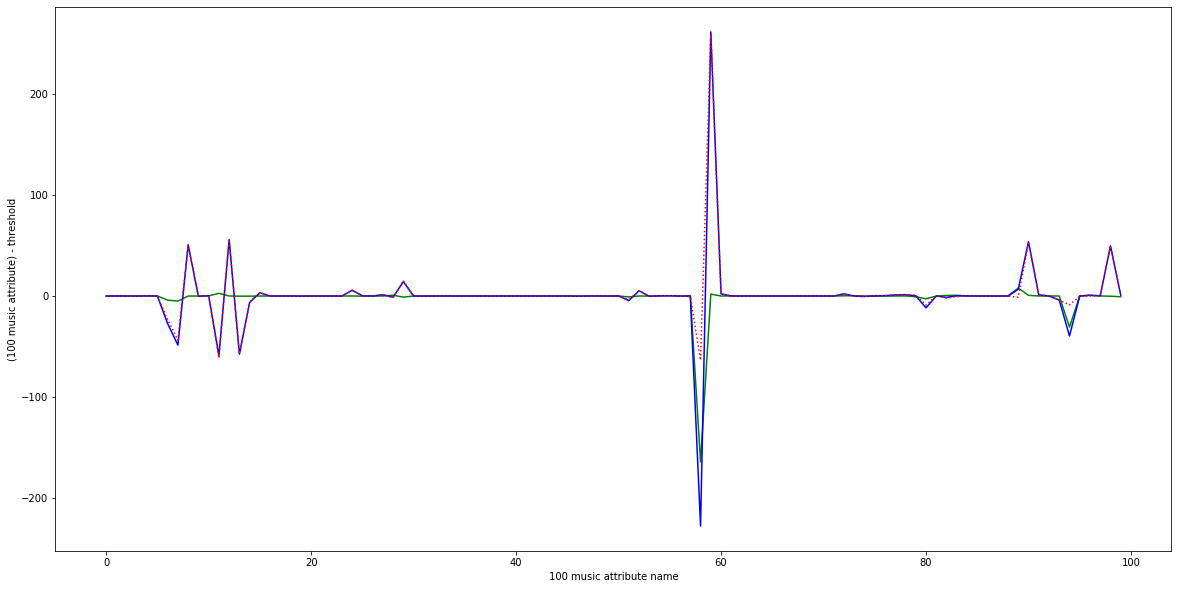

In [85]:
plt.figure(figsize=(20,10))
# train(-100~)
plt.plot(all_train_data_threshold_average , color="green") #, marker="o") 
# Russell(+200~) 
plt.plot(all_russell_data_threshold_average , color="blue") 
# ↓ Russell(+200~) - train(-100~)
plt.plot(all_russell_data_threshold_average - all_train_data_threshold_average, color="red" , linestyle="dotted") 


plt.xlabel('100 music attribute name')
plt.ylabel('(100 music attribute) - threshold')
plt.show()

4. ピークの部分を取得

In [73]:
for i in range(100):
    if ((all_russell_data_threshold_average[i] - all_train_data_threshold_average[i]) > 1):
        print('Big (Russell - train) = ' + str(i))
    if (all_russell_data_threshold_average[i] > 1):
        print('Big Russell = ' + str(i))
    if (all_train_data_threshold_average[i] > 1):
        print('Big train = ' + str(i))

Big (Russell - train) = 8
Big Russell = 8
Big train = 11
Big (Russell - train) = 12
Big Russell = 12
Big (Russell - train) = 15
Big Russell = 15
Big (Russell - train) = 24
Big Russell = 24
Big (Russell - train) = 27
Big Russell = 27
Big (Russell - train) = 29
Big Russell = 29
Big (Russell - train) = 52
Big Russell = 52
Big (Russell - train) = 59
Big Russell = 59
Big train = 59
Big (Russell - train) = 60
Big Russell = 60
Big (Russell - train) = 72
Big Russell = 72
Big (Russell - train) = 77
Big Russell = 77
Big (Russell - train) = 78
Big Russell = 78
Big Russell = 89
Big train = 89
Big (Russell - train) = 90
Big Russell = 90
Big (Russell - train) = 91
Big Russell = 91
Big (Russell - train) = 98
Big Russell = 98
Big (Russell - train) = 99


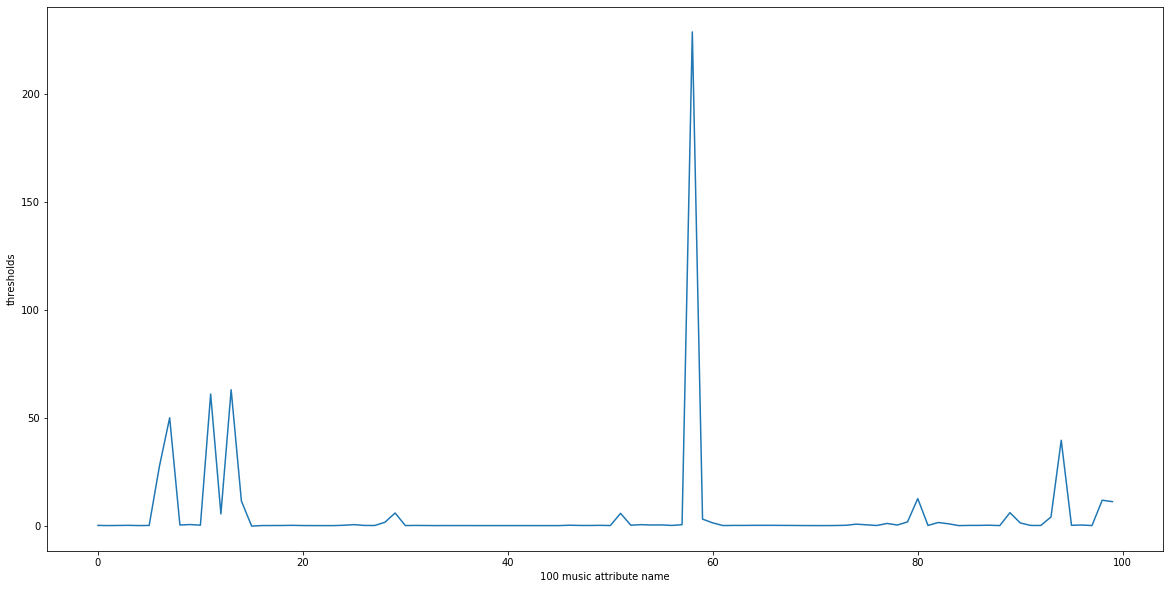

In [90]:
plt.figure(figsize=(20,10))
plt.plot(thresholds) 
plt.xlabel('100 music attribute name')
plt.ylabel('thresholds')
plt.show()

In [74]:
for i in range(100):
    if (thresholds[i] > 1):
        print('Big  thresholds = ' + str(i))

Big  thresholds = 6
Big  thresholds = 7
Big  thresholds = 11
Big  thresholds = 12
Big  thresholds = 13
Big  thresholds = 14
Big  thresholds = 28
Big  thresholds = 29
Big  thresholds = 51
Big  thresholds = 58
Big  thresholds = 59
Big  thresholds = 60
Big  thresholds = 79
Big  thresholds = 80
Big  thresholds = 82
Big  thresholds = 89
Big  thresholds = 90
Big  thresholds = 93
Big  thresholds = 94
Big  thresholds = 98
Big  thresholds = 99


5. バランス調整してもうまくいかない  
→ Russellの実際の音楽データと、回帰予測データで、予測の桁数が違う  
→ Russellのデータを、**入力回帰モデルの予測データ**に変更してみる

In [72]:
# 3＋. 予測Russellデータ (100つの属性値・閾値処理×)
all_predict_russell_data = np.load('./all_Russell_predict_data.npz')['arr_0'] # 閾値処理❌
all_predict_russell_data_threshold = []
for j in range(1071):
    all_predict_russell_data_threshold.append(all_predict_russell_data[j] - np.squeeze(thresholds))
all_predict_russell_data_threshold = np.squeeze(np.array(all_predict_russell_data_threshold))
all_predict_russell_data_threshold_average = np.mean(all_predict_russell_data_threshold , axis=0)
#print(all_predict_russell_data_threshold_average)
print(np.linalg.norm(all_predict_russell_data_threshold_average))

# 重みを作成
predict_russell_train_weight = all_train_data_threshold_average / all_predict_russell_data_threshold_average
print(predict_russell_train_weight)
print(russell_train_weight)
#np.savez('predict_russell_train_weight',predict_russell_train_weight,)


379.70868953584386
[ 1.40982249e-01  6.72073354e-01 -1.46274994e+00  2.33879579e-01
  3.27643891e-01 -6.36875190e-01  1.49350167e-01  1.02771878e-01
 -9.15752159e-04 -1.70590452e-02  2.88578266e-01 -4.57087819e-02
  3.10114811e-04  2.36249347e-03  2.09097006e-02 -4.20786993e-03
 -2.55290285e-01 -3.72105128e+00  4.36892870e-03  4.80102743e-01
  7.26486080e-01 -1.54832122e+00  6.17014908e+00  4.33272584e+00
  6.90168811e-03 -3.98676498e-01 -3.33187435e-02  1.33709457e-02
 -8.11442161e-01 -8.02504471e-02 -5.49459339e-01  2.71545944e-01
 -1.42575259e+00  3.23284424e-02  1.44031773e+00  2.20862113e-01
  3.59852478e-01  4.58762567e-01 -2.48797145e-01 -1.02920306e+00
  7.36626302e-01  1.11396613e+00 -2.73059720e+00  2.21199781e-01
  3.00812435e+00  7.60995098e-01  3.13508772e-02 -7.54837100e-01
  9.33123600e-02 -6.32209475e-01 -1.60149019e-02  1.96195324e-01
  3.06267665e-03  2.44655038e-01  4.77215903e-01  5.22497784e-01
 -7.59805495e-02 -2.08309725e+00  7.20929604e-01  7.18491861e-03
  0.00

### t-SNEで、**EMOPIA**の音楽属性値を可視化

In [20]:
# Q1 ~ Q4
x0 = all_russell_data00['xy_data'].values
x0 = np.array(x0)
x = np.zeros((0,2))
for xx in x0:
    x = np.append(x,np.array(ast.literal_eval(xx)))
x = x.reshape(1071, 2)
print(x.shape)


x_Q1_4 = []
#plt.scatter(a,b)
color_list = [ "g", "y" ,"m", "c"] #, "k"]
for n in range(len(x[:,0])):
    if (x[n,0] >= 0 )& (x[n,1] >= 0):
        x_Q1_4.append(1)  #plt.scatter(a[n], b[n], 20 ,color_list[0])
    elif (x[n,0] >= 0 )& (x[n,1] < 0):
        x_Q1_4.append(4)
    elif (x[n,0] < 0 )& (x[n,1] >= 0):
        x_Q1_4.append(2)
    else:
        x_Q1_4.append(3)

x_Q1_4 = np.array(x_Q1_4)  
print(x_Q1_4)      

(1071, 2)
[3 2 4 ... 1 2 4]


In [23]:
# t-SNEの適用
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2) # n_componentsは低次元データの次元数
X_tsne = tsne.fit_transform(all_russell_data)

Text(0, 0.5, 't-SNE Feature2')

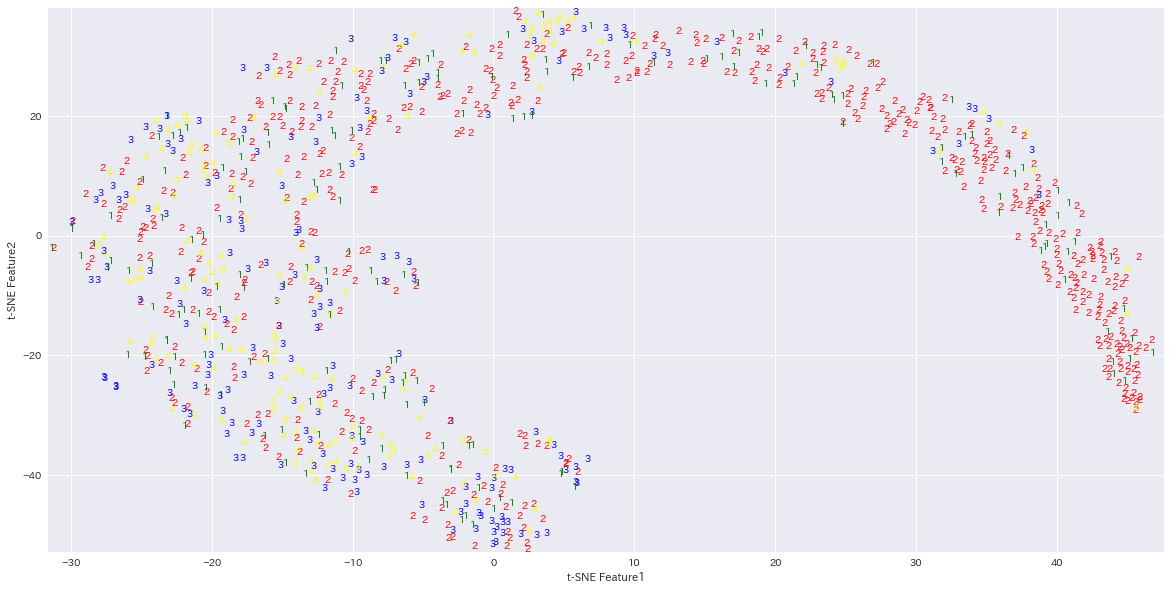

In [30]:
from matplotlib import pyplot as  plt
import seaborn as sns
import japanize_matplotlib
import numpy as np

plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'IPAexGothic'  

colors = ['green', 'red', 'blue', 'yellow'] #, 'tomato', 'purple', 'black', 'olive', 'lightblue', 'lime']
plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)
# plt.ylim(X_tsne[:, 2].min(), X_tsne[:, 2].max() + 1) # 08/17
for i in range(len(all_russell_data)):
    plt.text(
        X_tsne[i, 0],
        X_tsne[i, 1],
        #str('*'), 
        str(x_Q1_4[i]),
        color = colors[x_Q1_4[i]-1]
        )
plt.xlabel('t-SNE Feature1')
plt.ylabel('t-SNE Feature2')


### 入力データの音楽属性値を拡散モデルの生成データの音楽属性値に合わせる

xy軸グラフの座標値(Russell上) が持つ音楽属性値を、**Trainデータ**が持つ音楽属性値と揃える  


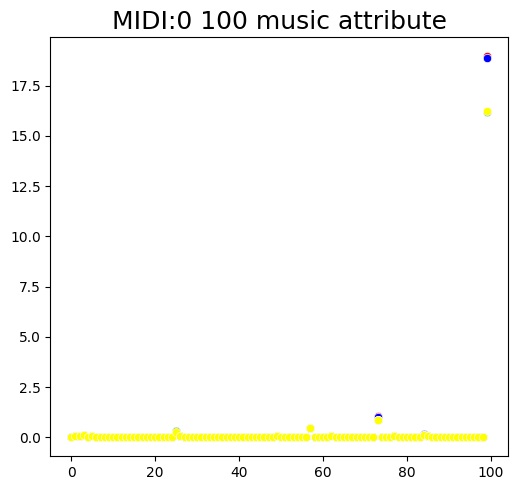

In [8]:
import torch as th
real_DEAM = th.load('./input_emotion_18_2_DEAM.pt')

from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("MIDI:0 100 music attribute", fontsize=18)

sns.scatterplot(data = real_DEAM[0,:], color="red")
sns.scatterplot(data = real_DEAM[1,:], color="blue")
sns.scatterplot(data = real_DEAM[2,:], color="green")
sns.scatterplot(data = real_DEAM[3,:], color="yellow")
#'''
plt.tight_layout()
plt.show()

[[ 9.60651799e-02  5.37689892e-02  8.26162596e-02  3.69120269e-02
   2.25304516e-02  7.15297931e-04  6.73198141e-01  8.22526416e-02
   2.12314284e-02  7.39690659e-03  5.15215586e-03  4.75814452e-03
   8.64483342e-04  7.90337456e-03  1.01745895e-03  1.42084353e-03
   7.40947283e-02  1.98707022e-01  5.09951028e-02  1.27178266e-01
   1.31221686e-01  1.39119072e-01  1.01762253e-01  6.78093546e-02
   2.08358327e-02 -3.92496522e-03  9.65057574e-02  7.20224821e-01
   1.50219798e+00  7.33009656e-02  6.57591107e-02  5.80893213e-02
   1.05102801e-01  8.25051611e-02  1.26697138e-01  1.09505602e+01]]


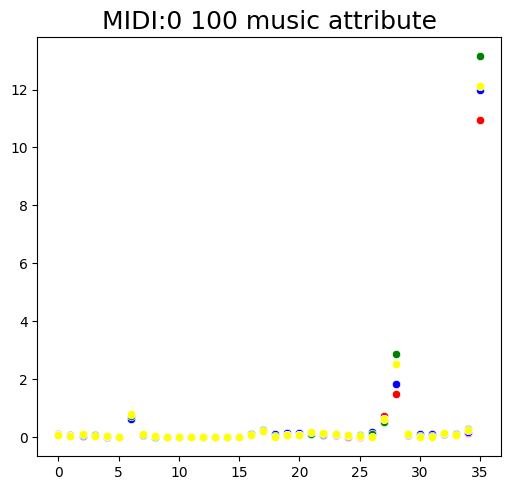

In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("MIDI:0 100 music attribute", fontsize=18)
'''
# EMOPIA座標データ (閾値処理あり)
sns.scatterplot(data = real_train1_threshold, color="red")
sns.scatterplot(data = real_train2_threshold, color="blue")
sns.scatterplot(data = real_train3_threshold, color="green")
sns.scatterplot(data = real_train4_threshold, color="yellow")
'''
#'''
number_a18_2 = [1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57, 62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99] # 音楽属性値18*2
# EMOPIA座標データ (閾値処理なし)
sns.scatterplot(data = np.append(np.zeros((0,100)),real_train1[:,number_a18_2]), color="red")
sns.scatterplot(data = np.append(np.zeros((0,100)),real_train2[:,number_a18_2]), color="blue")
sns.scatterplot(data = np.append(np.zeros((0,100)),real_train3[:,number_a18_2]), color="green")
sns.scatterplot(data = np.append(np.zeros((0,100)),real_train4[:,number_a18_2]), color="yellow")
print(real_train1[:,number_a18_2])
#'''
'''
# 実際のTrainデータ　(閾値処理あり)
sns.scatterplot(data = real_train[0], color="red")
sns.scatterplot(data = real_train[1], color="blue")
sns.scatterplot(data = real_train[2], color="green")
sns.scatterplot(data = real_train[3], color="yellow")
'''
plt.tight_layout()
plt.show()

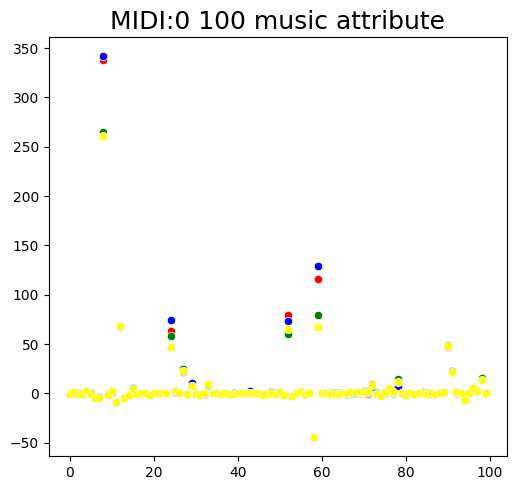

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("MIDI:0 100 music attribute", fontsize=18)
'''
# EMOPIA座標データ (閾値処理あり) # *thresholds_weight0[0,:].numpy()
sns.scatterplot(data = real_train1_threshold*thresholds_weight0[0,:].numpy(), color="red")
sns.scatterplot(data = real_train2_threshold*thresholds_weight0[0,:].numpy(), color="blue")
sns.scatterplot(data = real_train3_threshold*thresholds_weight0[0,:].numpy(), color="green")
sns.scatterplot(data = real_train4_threshold*thresholds_weight0[0,:].numpy(), color="yellow")
'''
#EMOPIA座標データ (閾値処理あり)
sns.scatterplot(data = real_train1_threshold, color="red")
sns.scatterplot(data = real_train2_threshold, color="blue")
sns.scatterplot(data = real_train3_threshold, color="green")
sns.scatterplot(data = real_train4_threshold, color="yellow")

plt.tight_layout()
plt.show()


* EMOPIAとTrainデータ：元々の音楽属性値(閾値処理なし)がそもそも一桁ぐらい違う  
* EMOPIA： 1.39790311e-002  9.60651799e-002  5.37689892e-002  8.26162596e-002
   1.49068892e-001  3.69120269e-002 ...
* Trainデータ：1.493e-01 0.000e+00 1.194e-01 2.090e-01 0.000e+00 1.045e-01 ...

In [ ]:
#trainデータの音楽属性
attribute_npzfile = np.load('../m21/attribute100_threshold_train_CFG.npz') # 閾値処理あり
print(attribute_npzfile['arr_0'][0])

# EMOPIA座標の音楽属性
print(real_train1) # (閾値処理なし)
# 桁数が１つ少ない！！！
print(real_train1_threshold )# 閾値処理あり・桁数２つ上がる

[ 1.13080723e+00 -2.19909272e-01  8.66240594e-01  1.30936772e+00
 -2.94950957e-01  5.28447912e-01 -1.65563317e+00 -1.57085878e+00
 -8.44165848e-01  9.25662612e-01  1.13305869e-01  3.00491065e-01
  4.28430832e-01 -8.65980387e-02 -1.04591653e+00  9.84252186e-01
  6.50936119e-01 -3.66514913e-01 -9.40915616e-01  6.30522234e-01
 -6.74865900e-01 -2.26838068e-01  0.00000000e+00  0.00000000e+00
  1.17158844e-01 -7.11390833e-02 -1.14404686e+00  1.01365395e+00
  1.91814150e+00 -2.21503558e+00 -4.39727009e-01 -3.85215022e-01
  7.11248509e-01 -4.49255684e-01 -7.32397430e-01 -2.82165675e-02
 -1.18853889e+00 -3.28515709e-01 -5.64458323e-01 -2.84410814e-01
 -1.37039618e-01 -2.33522943e-01 -1.87627957e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.06929988e-01  5.16281095e-01
 -5.26512744e-01  7.92138620e-03  2.32851263e+00 -2.15074682e-01
 -5.61953975e-01 -3.76959449e-01 -2.16768222e-03  8.08663206e-02
  1.22349643e+00 -1.10797898e-01 -3.16357898e+01  1.42309727e+00
  0.00000000e+00 -8.75408

In [69]:
# ピアソン相関係数
print("-" +str(np.corrcoef(real_train2_threshold , real_train1_threshold)[0,1])) # -1 ~ 1cpr 
print("-" +str(np.corrcoef(real_train2_threshold , real_train3_threshold)[0,1]))
print("-" +str(np.corrcoef(real_train3_threshold , real_train4_threshold)[0,1]))
print("-" +str(np.corrcoef(real_train4_threshold , real_train1_threshold)[0,1]))
print("-" +str(np.corrcoef(real_train3_threshold , real_train1_threshold)[0,1]))
print("-" +str(np.corrcoef(real_train2_threshold , real_train4_threshold)[0,1]))


print("-" +str(np.corrcoef(real_train[1] , real_train[0])[0,1]))
print("-" +str(np.corrcoef(real_train[1] , real_train[2])[0,1]))
print("-" +str(np.corrcoef(real_train[2] , real_train[3])[0,1]))
print("-" +str(np.corrcoef(real_train[0] , real_train[3])[0,1]))
print("-" +str(np.corrcoef(real_train[0] , real_train[2])[0,1]))
print("-" +str(np.corrcoef(real_train[1] , real_train[3])[0,1]))

-0.9990084002983038
-0.9940539292727801
-0.998293501239175
-0.9931598744658588
-0.994765947098101
-0.9898517187427919
-0.9254691397763324
-0.9623747692608292
-0.9477568256889843
-0.9360711279794353
-0.922796917257539
-0.9711886851485521


* validデータの推定象限

In [20]:
import numpy as np
traindataArousal= np.load('../validdata_Arousal.npz')['a']
traindataValence = np.load('../validdata_valence.npz')['a']

print(traindataValence.shape)
print(len(traindataArousal.tolist()))

(19955,)
19955


In [21]:
Q1 = 0
Q2 = 0
Q3 = 0
Q4 = 0

for i in range(len(traindataArousal.tolist())):
    if traindataArousal[i]=='HA':
        if traindataValence[i] =='HV':
            Q1 = Q1 + 1
        else:
            Q2 = Q2 + 1
    else:
        if traindataValence[i] =='HV':
            Q4 = Q4 + 1
        else:
            Q3 = Q3 + 1

print('Q1 = '+str(Q1))
print('Q2 = '+str(Q2))
print('Q3 = '+str(Q3))
print('Q4 = '+str(Q4))

Q1 = 7473
Q2 = 31
Q3 = 23
Q4 = 12428


In [16]:
print(traindataValence[:1000])

['HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV' 'HV'
 'HV' 

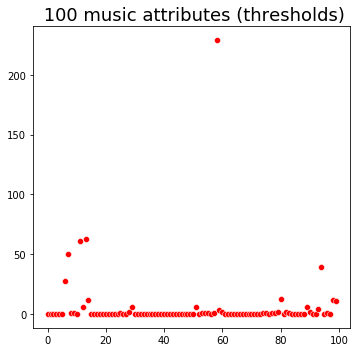

In [40]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sc = StandardScaler() 

thresholds = np.squeeze(np.load("../../../../../../data/threshold.npy", allow_pickle=True)) #閾値

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title(" 100 music attributes (thresholds)", fontsize=18)
sns.scatterplot(data = thresholds, color="red")
plt.tight_layout()
plt.show()

## EMOPIA内データについての分析　

* Valence・Arousal合わせて、ラベルと推定VA(High/Low)が一致しているもの

In [9]:
import torch
import numpy as np
import pandas as pd

df_EMOPIA_VA = pd.read_csv('../dataset/sample_data/emotion_valence_arousal.csv')
#print(df_EMOPIA_VA)

file_name = df_EMOPIA_VA['file'].values #scipy.stats.zscore
files = []
for file in file_name:
    files.append(file[:2])
V_HL = df_EMOPIA_VA['Valence'].values#df_EMOPIA_VA['Inference values V'].values #scipy.stats.zscore
A_HL = df_EMOPIA_VA['Arousal'].values#df_EMOPIA_VA['Inference values A'].values #scipy.stats.zscore


True_filenumber = []
for n in range(len(files)):
    if (V_HL[n] == 'HV')&(A_HL[n] == 'HA'):
        VA_HL = 'Q1'
        if files[n] == VA_HL:
            True_filenumber.append(n)
    if (V_HL[n] == 'LV')&(A_HL[n] == 'HA'):
        VA_HL = 'Q2'
        if files[n] == VA_HL:
            True_filenumber.append(n)
    if (V_HL[n] == 'LV')&(A_HL[n] == 'LA'):
        VA_HL = 'Q3'
        if files[n] == VA_HL:
            True_filenumber.append(n)
    if (V_HL[n] == 'HV')&(A_HL[n] == 'LA'):
        VA_HL = 'Q4'
        if files[n] == VA_HL:
            True_filenumber.append(n)
print(True_filenumber)
print(len(True_filenumber))


[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 40, 41, 43, 44, 45, 46, 49, 53, 54, 55, 58, 62, 63, 65, 66, 67, 69, 72, 73, 74, 76, 77, 79, 81, 82, 84, 86, 87, 89, 93, 95, 96, 97, 99, 102, 103, 105, 106, 107, 110, 113, 115, 116, 117, 118, 119, 120, 121, 123, 126, 127, 128, 129, 130, 131, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 152, 154, 155, 159, 161, 162, 164, 165, 168, 171, 172, 173, 174, 175, 179, 180, 181, 184, 187, 189, 196, 197, 198, 202, 203, 204, 206, 207, 210, 212, 213, 215, 216, 218, 220, 221, 223, 224, 225, 229, 230, 233, 235, 237, 239, 242, 244, 245, 248, 249, 250, 252, 257, 259, 260, 264, 269, 270, 272, 273, 274, 275, 276, 278, 279, 280, 281, 282, 283, 285, 286, 287, 289, 290, 296, 299, 300, 302, 305, 306, 308, 309, 310, 311, 313, 315, 316, 317, 318, 320, 322, 323, 325, 326, 327, 330, 331, 334, 336, 337, 338, 339, 340, 342, 344, 346, 347, 348, 352, 355, 360, 362, 363, 364, 365, 366, 367

* Valence・Arousal別々で、それぞれの推定VA(High/Low)の正解推定度を見る

In [10]:
True_filenumber_Valence = []
High_True_filenumber_Valence =[]
Low_True_filenumber_Valence =[]
for va in range(len(files)):
    if (V_HL[va] == 'HV'):
        if files[va] == 'Q1' or  files[va] == 'Q4':
            True_filenumber_Valence.append(va)
            High_True_filenumber_Valence.append(va)
    if (V_HL[va] == 'LV'):
        if files[va] == 'Q2' or files[va] == 'Q3':
            True_filenumber_Valence.append(va)
            Low_True_filenumber_Valence.append(va)
print(True_filenumber_Valence)
print(len(True_filenumber_Valence))


True_filenumber_Arousal = []
High_True_filenumber_Arousal =[]
Low_True_filenumber_Arousal =[]
for ar in range(len(files)):
    if (A_HL[ar] == 'HA'):
        if files[ar] == 'Q1' or files[ar] == 'Q2':
            True_filenumber_Arousal.append(ar)
            High_True_filenumber_Arousal.append(ar)
    if (A_HL[n] == 'LA'):
        if files[ar] == 'Q3' or files[ar] == 'Q4':
            True_filenumber_Arousal.append(ar)
            Low_True_filenumber_Arousal.append(ar)
np.savez('True_filenumber_V_A', True_filenumber_Valence, True_filenumber_Arousal)
print(True_filenumber_Arousal)
print(len(True_filenumber_Arousal))

[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 49, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 102, 103, 105, 106, 107, 110, 111, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 159, 160, 161, 162, 164, 165, 168, 170, 171, 172, 173, 174, 175, 176, 179, 180, 181, 182, 184, 187, 188, 189, 190, 193, 194, 195, 196, 197, 198, 202, 203, 204, 206, 207, 208, 210, 212, 213, 214, 215, 216, 218, 219, 220, 221, 223, 224, 225, 228, 229, 230, 231, 232, 233, 235, 237, 239, 242, 243, 244, 245, 247, 248, 249, 250, 252, 257, 259, 260, 261, 264, 266, 269, 270, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289, 290, 2

* 正解データのファイル番号を取り出す

In [11]:
df_EMOPIA_Q1_4 = pd.read_csv('../dataset/sample_data/emotion.csv')

file_name = df_EMOPIA_Q1_4['file'].values #scipy.stats.zscore
files = []

True_filenumber_all = []
for file in file_name:
    files.append(file[:2])
Q1_4 = df_EMOPIA_Q1_4['emotion'].values

for j in range(len(files)):
    if Q1_4[j] == files[j]:
        True_filenumber_all.append(j)
print(True_filenumber_all)
print(len(True_filenumber_all))

[1, 2, 3, 5, 6, 7, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 58, 60, 62, 63, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 101, 102, 103, 105, 106, 107, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121, 123, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 142, 143, 144, 146, 147, 148, 149, 150, 152, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 184, 185, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 202, 203, 204, 206, 207, 209, 210, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 242, 244, 245, 247, 248, 249, 250, 252, 254, 257, 259, 260, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 276, 278, 279, 281, 282, 283, 284, 285, 286, 287, 28

* 正しいデータから**座標値**と**音楽属性値**を取り出す

In [12]:
# #音楽属性値の0,1の値を決める関数
def binarize_command(command, thresholds):
        discrete_feature = []
        # commandtanh = np.tanh(command) #05/18 閾値 → tanh
        # discrete_feature.append(commandtanh) #05/18
        #discrete_feature.append(command) 
        for k in range(command.shape[0]):
            thres = thresholds[k]
            discrete_feature.append(np.searchsorted(thres, command[k]))
        return discrete_feature
thresholds = np.load("../../../../../../data/threshold.npy", allow_pickle=True) #閾値
feature_index = np.load("../../../../../../data/feature_index.npy", allow_pickle=True) #特徴量100


In [13]:
import ast

# 文字列を数字に
# 座標値・音楽属性値を同時に取得
def str_to_float(list_str_coordinate , list_str_attribute):
    list_str_coordinate = np.array(list_str_coordinate)
    list_str_attribute = np.array(list_str_attribute)
    #print(t0)
    list_float_coordinate = np.zeros((0,2))
    list_float_attribute = np.zeros((0,1496))
    
    for t in list_str_coordinate:
        t = np.array(ast.literal_eval(t))
        list_float_coordinate = np.append(list_float_coordinate,t)
    for tt in list_str_attribute:
        tt = np.array(ast.literal_eval(tt))
        list_float_attribute  = np.append(list_float_attribute,tt)
        
    #print(t)
    list_float_coordinate = list_float_coordinate.reshape(len(list_str_coordinate), 2)
    list_float_attribute = list_float_attribute.reshape(len(list_str_attribute), 1496)
    #print(t.shape)
    #print(t)
    return list_float_coordinate , list_float_attribute

In [14]:
df_coor_attri = pd.read_csv('../xydata_attribute.csv')
coordinate = df_coor_attri['xy_data'].values
arrtibute = df_coor_attri['Attribute'].values

correct_coordinate , correct_attribute = str_to_float(coordinate[True_filenumber] , arrtibute[True_filenumber]) 
print(correct_coordinate)

[[-0.29766115 -0.50818175]
 [-0.22399868  0.30127617]
 [ 0.38721552 -0.97975359]
 ...
 [ 0.19345123  0.46203513]
 [-0.22903825  0.20931215]
 [ 0.22781984 -0.60271735]]


* Valence・Arousal別々に

In [15]:
correct_coordinate_Valence , correct_attribute_Valence = str_to_float(coordinate[True_filenumber_Valence] , arrtibute[True_filenumber_Valence])
correct_coordinate_Arousal , correct_attribute_Arousal = str_to_float(coordinate[True_filenumber_Arousal] , arrtibute[True_filenumber_Arousal])

# High・Low別々に
High_correct_coordinate_Valence , High_correct_attribute_Valence = str_to_float(coordinate[High_True_filenumber_Valence] , arrtibute[High_True_filenumber_Valence])
Low_correct_coordinate_Valence , Low_correct_attribute_Valence = str_to_float(coordinate[Low_True_filenumber_Valence] , arrtibute[Low_True_filenumber_Valence])
High_correct_coordinate_Arousal , High_correct_attribute_Arousal = str_to_float(coordinate[High_True_filenumber_Arousal] , arrtibute[High_True_filenumber_Arousal])
Low_correct_coordinate_Arousal , Low_correct_attribute_Arousal = str_to_float(coordinate[Low_True_filenumber_Arousal] , arrtibute[Low_True_filenumber_Arousal])

In [16]:
correnct_attribute_Valence_100_01 = []
correnct_attribute_Arousal_100_01 = []

# Valence
for k ,t_k in enumerate(correct_attribute_Valence):
    binary_command = binarize_command(correct_attribute_Valence[k][feature_index], thresholds)
    correnct_attribute_Valence_100_01.append(binary_command)
correnct_attribute_Valence_100_01 = np.squeeze(np.array(correnct_attribute_Valence_100_01))

# Arousal
for k ,t_k in enumerate(correct_attribute_Arousal):
    binary_command = binarize_command(correct_attribute_Arousal[k][feature_index], thresholds)
    correnct_attribute_Arousal_100_01.append(binary_command)
correnct_attribute_Arousal_100_01 = np.squeeze(np.array(correnct_attribute_Arousal_100_01))


print(correnct_attribute_Valence_100_01.shape)
print(correnct_attribute_Arousal_100_01.shape)

(772, 100)
(1064, 100)


In [17]:
# High・Low別
High_correnct_attribute_Valence_100_01 = []
High_correnct_attribute_Arousal_100_01 = []
Low_correnct_attribute_Valence_100_01 = []
Low_correnct_attribute_Arousal_100_01 = []

# High Valence
for k ,t_k in enumerate(High_correct_attribute_Valence):
    binary_command = binarize_command(High_correct_attribute_Valence[k][feature_index], thresholds)
    High_correnct_attribute_Valence_100_01.append(binary_command)
High_correnct_attribute_Valence_100_01 = np.squeeze(np.array(High_correnct_attribute_Valence_100_01))
# Low Valence
for k ,t_k in enumerate(Low_correct_attribute_Valence):
    binary_command = binarize_command(Low_correct_attribute_Valence[k][feature_index], thresholds)
    Low_correnct_attribute_Valence_100_01.append(binary_command)
Low_correnct_attribute_Valence_100_01 = np.squeeze(np.array(Low_correnct_attribute_Valence_100_01))


# High Arousal
for k ,t_k in enumerate(High_correct_attribute_Arousal):
    binary_command = binarize_command(High_correct_attribute_Arousal[k][feature_index], thresholds)
    High_correnct_attribute_Arousal_100_01.append(binary_command)
High_correnct_attribute_Arousal_100_01 = np.squeeze(np.array(High_correnct_attribute_Arousal_100_01))
# Low Arousal
for k ,t_k in enumerate(Low_correct_attribute_Arousal):
    binary_command = binarize_command(Low_correct_attribute_Arousal[k][feature_index], thresholds)
    Low_correnct_attribute_Arousal_100_01.append(binary_command)
Low_correnct_attribute_Arousal_100_01 = np.squeeze(np.array(Low_correnct_attribute_Arousal_100_01))


print(High_correnct_attribute_Valence_100_01.shape)
print(Low_correnct_attribute_Valence_100_01.shape)
print(High_correnct_attribute_Arousal_100_01.shape)
print(Low_correnct_attribute_Arousal_100_01.shape)

(307, 100)
(465, 100)
(502, 100)
(562, 100)


* 「各音楽属性が1(=属性が音楽内に存在する)」となる音楽の合計値  
→ 平均値をプロット  
→ HighとLowの差が大きいものを、**重要な音楽属性値**と設定  
* Valence🟩 → Low(--)、差は🟦    
* Arousal🟥 → Low(--)、差は🩷 

[ 38 264  73 115 300  68   0   0 307  17 307   0 307   0   0 307   0  47
 183   0 174  51  15  19 307 280 200 299   0 307   0   2 115 307 153 244
   2 163  14  25 130  84  24 129  66  54   0  63 245  53 273   0 307   0
 305 299  28  31]
[ 79 333 236  92 441 235   0   0 464  61 449   0 464   0   0 465   0 105
 240   0 199  88  79  62 464 376 226 446   0 464   0   1 129 463 234 321
   7 297  56  76 274 256  96 303 184 173   0 124 355 176 384   0 464   2
 454 431  21  97]
[  0 501 499 217 188 353 280 282 270 292 248 293 270 126 499 163  33 481
 470 396 434 301   0 218   0 501 219 236 247  23 232 490 501 501 387   0
   0 119 501 501 501 222]
[  0 562 504 203  50 156 114 262 282 425 440 513 504 375 549  53   6 479
 561 552 541 333   0 378   0 562 108  95 279 182 298 525 562 562 372   0
   0 485 562 561 562 417]
HighとLowの平均個数の差をプロット!!
[0.04611397 0.14380582 0.26974187 0.17674337 0.0288116  0.28387797
 0.         0.         0.00215054 0.0758082  0.0344086  0.
 0.00215054 0.         0.        

/Users/kawabemoyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kawabemoyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


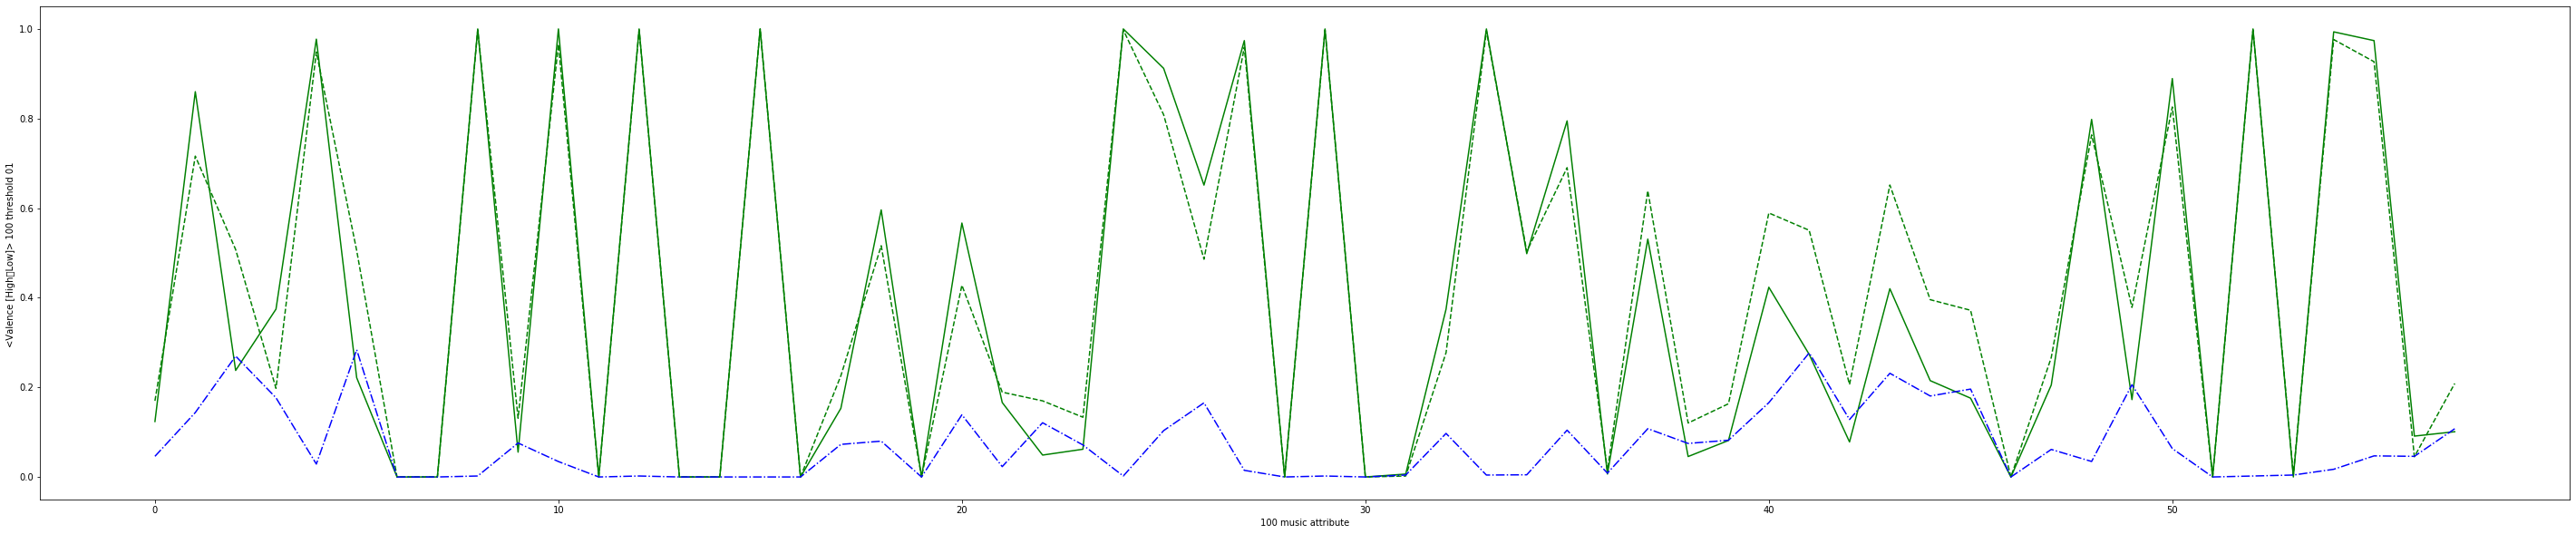

/Users/kawabemoyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kawabemoyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


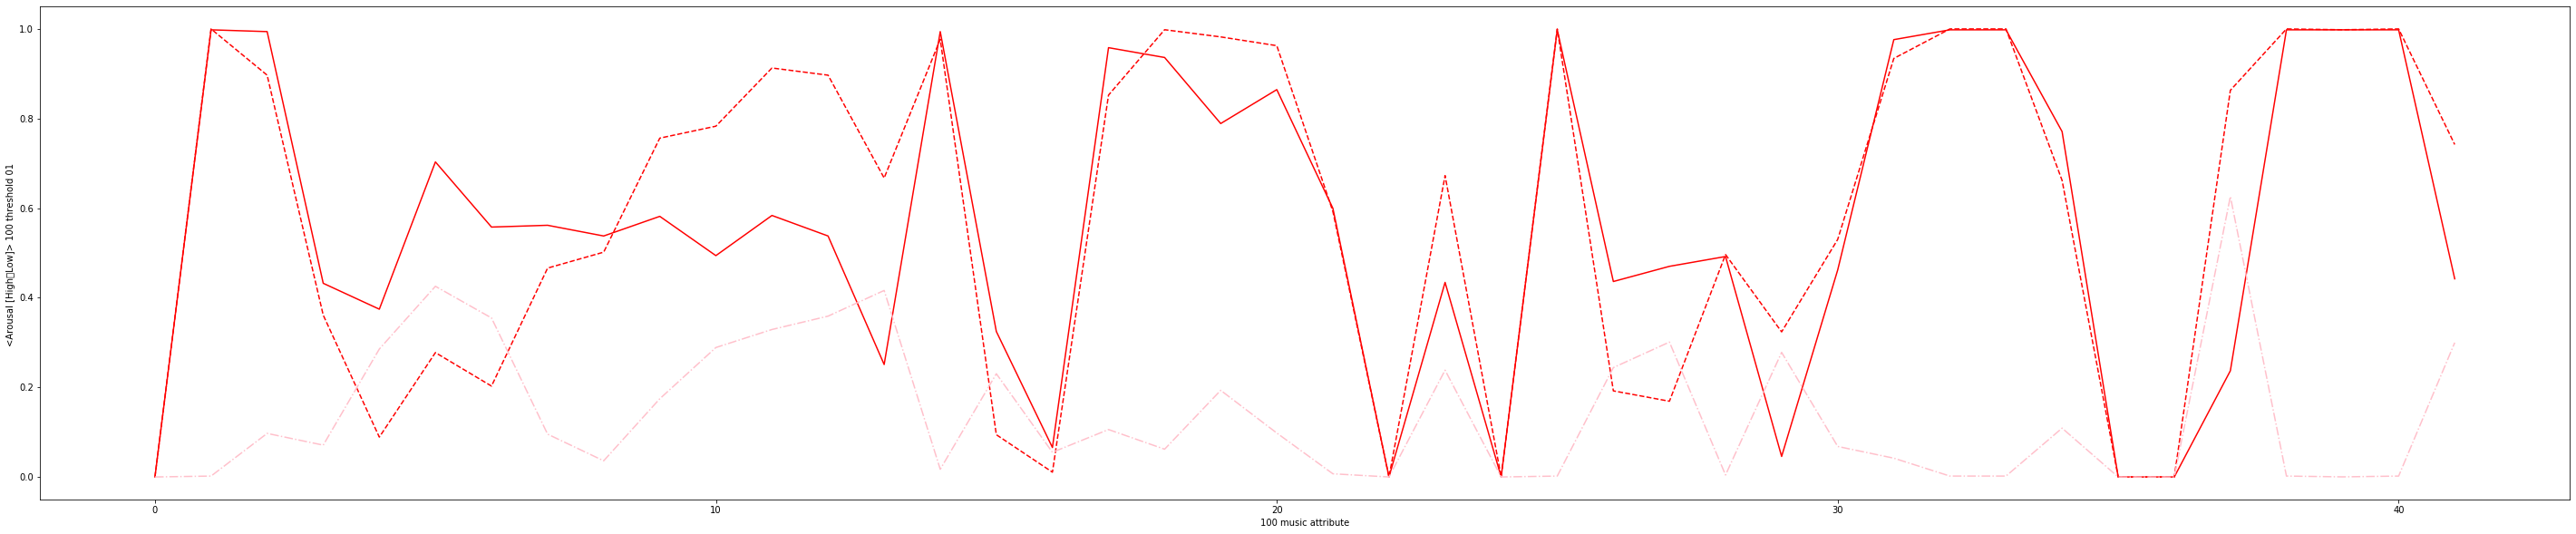

In [ ]:
# 1となる音楽の個数
print(sum(High_correnct_attribute_Valence_100_01)[:58])
print(sum(Low_correnct_attribute_Valence_100_01)[:58])
print(sum(High_correnct_attribute_Arousal_100_01)[58:])
print(sum(Low_correnct_attribute_Arousal_100_01)[58:])
print('HighとLowの平均個数の差をプロット!!')
print(abs(sum(High_correnct_attribute_Valence_100_01)[:58]/307 - sum(Low_correnct_attribute_Valence_100_01)[:58]/465))
print(abs(sum(High_correnct_attribute_Arousal_100_01)[58:]/502 - sum(Low_correnct_attribute_Arousal_100_01)[58:]/562))

#from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# Valence：0~57
plt.figure(figsize=(50,10))
plt.plot(sum(High_correnct_attribute_Valence_100_01)[:58]/307 , color='green')  # plt.bar(np.arange(58),sum(High_correnct_attribute_Valence_100_01)[:58]/307) 
plt.plot(sum(Low_correnct_attribute_Valence_100_01)[:58]/465 , ls="--", color='green') # plt.bar(np.arange(58),sum(Low_correnct_attribute_Valence_100_01)[:58]/465)
# High・Lowの差(絶対値)
plt.plot(abs(sum(High_correnct_attribute_Valence_100_01)[:58]/307 - sum(Low_correnct_attribute_Valence_100_01)[:58]/465), ls="-.", color='blue')
plt.xlabel('100 music attribute')
plt.ylabel('<Valence [High・Low]> 100 threshold 01 ')
plt.show()

# Arousal:58~
plt.figure(figsize=(50,10))
plt.plot(sum(High_correnct_attribute_Arousal_100_01)[58:]/502,color='red') 
plt.plot(sum(Low_correnct_attribute_Arousal_100_01)[58:]/562, ls="--", color='red') 
# High・Lowの差(絶対値)
plt.plot(abs(sum(High_correnct_attribute_Arousal_100_01)[58:]/502 - sum(Low_correnct_attribute_Arousal_100_01)[58:]/562), ls="-.", color='pink')
plt.xlabel('100 music attribute')
plt.ylabel('<Arousal [High・Low]> 100 threshold 01 ')
plt.show()

#plt.ylabel('100 threshold 01 <Valence/Arousal [High・Low]>')
#plt.show()

### Q1~4の「0,1」の平均音楽属性値について
1. 0.1で表す音楽属性値100つについて、emoGenのQ1〜4平均音楽属性値を確認　→ 象限間でどれぐらい異なるかを確認

In [ ]:
Q1_4average = np.squeeze(np.load("../../../../../../data/infer_input/inference_command.npy", allow_pickle=True)) #Q1_4の平均
def Q1_4_diff(Q1_4average_diff):
    print(Q1_4average_diff)
    index=[]
    for k, thre in enumerate(Q1_4average_diff):
        if thre != 0:
            index.append(k)
    return index
 
print('Q2 - Q1')      
print(Q1_4_diff(Q1_4average[1]-Q1_4average[0]))
print('\n')
print('Q3 - Q2') 
print(Q1_4_diff(Q1_4average[2]-Q1_4average[1]))
print('\n')
print('Q4 - Q3') 
print(Q1_4_diff(Q1_4average[3]-Q1_4average[2]))
print('\n')
print('Q1 - Q4') 
print(Q1_4_diff(Q1_4average[0]-Q1_4average[3]))
print('\n')
print('Q3 - Q1') 
print(Q1_4_diff(Q1_4average[2]-Q1_4average[0]))
print('\n')
print('Q4 - Q2') 
print(Q1_4_diff(Q1_4average[3]-Q1_4average[1]))
print('\n')

### **Valence**のみ変化 
* 象限間の「0,1の差」をプロット   
Q2 - Q1 (負の変化)  
Q4 - Q3　(正の変化)

* ピッチ：0~15  
* メロディー：16~29  
* コード：30~57

Q2 - Q1
[ 0  1 -1 -1 -1 -1  0  0  1  0  0  0  0 -1  0 -1 -1  0 -1  0  0 -1 -1  0
  1  0  0 -1  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0
  1 -1  0  0  1  0  1  0  0  1]
[1, 2, 3, 4, 5, 8, 13, 15, 16, 18, 21, 22, 24, 27, 30, 31, 43, 44, 48, 49, 52, 54, 57]


Q4 - Q3
[ 1  0  0  1 -1  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0  0 -1  1  0
 -1 -1  1  0  0  0  0  1  1  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0
 -1  1  0  0 -1  1  0  0  0  0]
[0, 3, 4, 6, 9, 18, 21, 22, 24, 25, 26, 31, 32, 38, 39, 40, 48, 49, 52, 53]


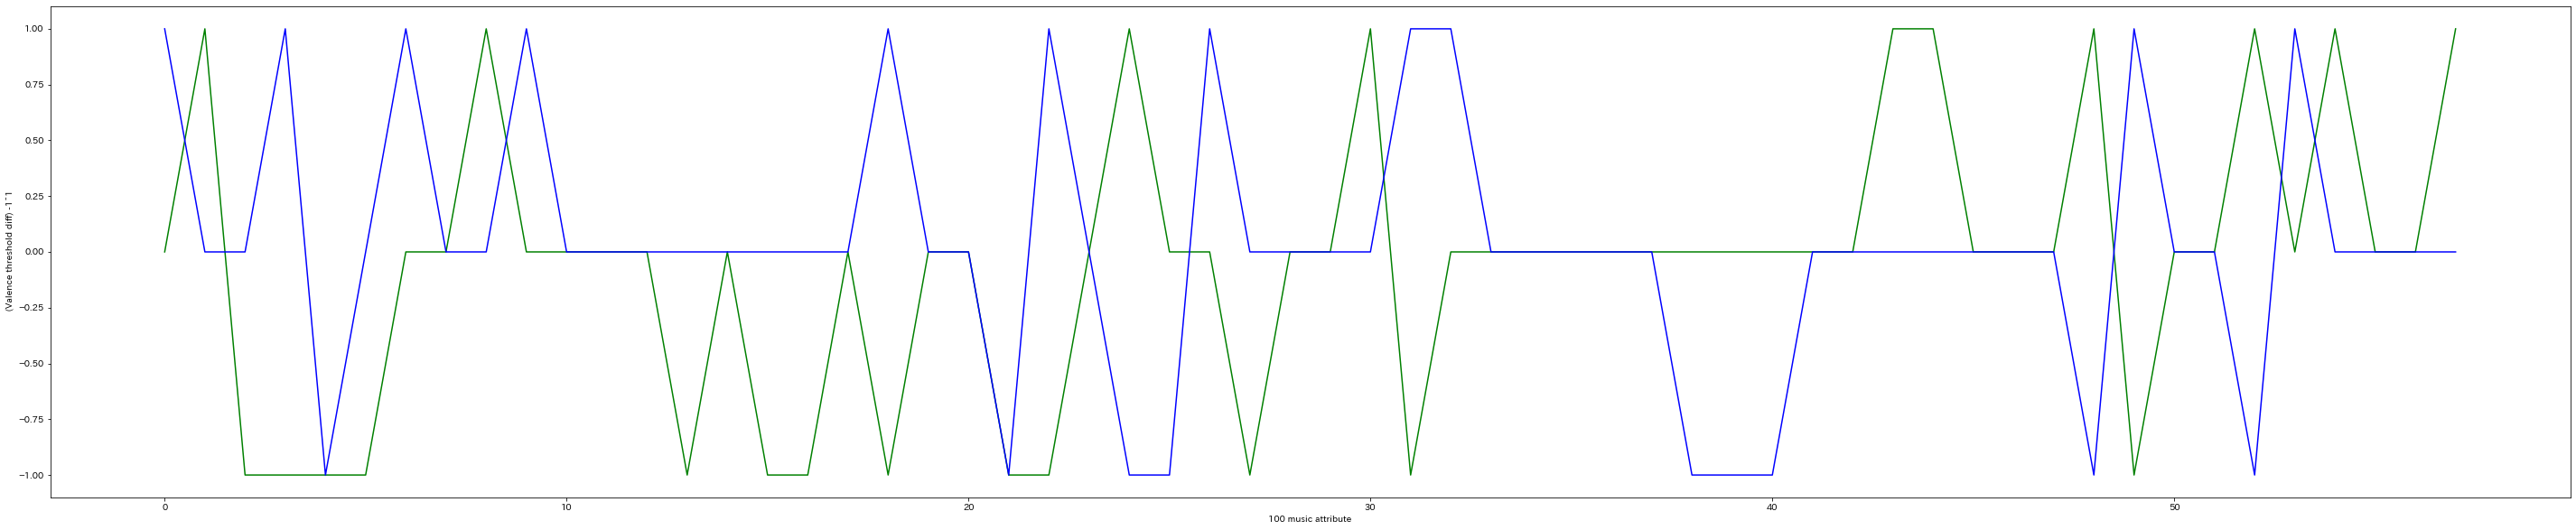

In [146]:
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import japanize_matplotlib
import numpy as np

print('Q2 - Q1')      
print(Q1_4_diff((Q1_4average[1]-Q1_4average[0])[:58]))
print('\n')
print('Q4 - Q3') 
print(Q1_4_diff((Q1_4average[3]-Q1_4average[2])[:58]))

plt.figure(figsize=(50,10))
plt.plot((Q1_4average[1]-Q1_4average[0])[:58] ,color='green') # Q2 - Q1 (負の変化)  
plt.plot((Q1_4average[3]-Q1_4average[2])[:58] ,color='blue') # Q4 - Q3　(正の変化)
plt.xlabel('100 music attribute')
plt.ylabel(' (Valence threshold diff) -1~1')
plt.show()



### **Arousal**のみ変化 
* 象限間の「0,1の差」をプロット   
Q3 - Q2 (負の変化)  
Q1 - Q4　(正の変化)

* リズム：58~93  
* リズム関連(テンポ・ダイナミクス)：94,95  
* テクスチャー：96,97  
* ダイナミクス：98,99

Q3 - Q2
[-1 -1  0  0  0 -1 -1  0  0  1  1  1  1  0  0  0 -1  1  1  0 -1  1 -1  1
 -1 -1  0  0  0  1  0 -1  0  0  0  0  1  1  1  1  1  1]
[0, 1, 5, 6, 9, 10, 11, 12, 16, 17, 18, 20, 21, 22, 23, 24, 25, 29, 31, 36, 37, 38, 39, 40, 41]


Q1 - Q4
[ 0  1  1  1  1  1  0  1  0  0 -1 -1  0 -1  1  1  1 -1 -1 -1  0 -1  1  1
  0  0  1  1 -1 -1  1  1  0  0  0  0 -1 -1  0  0 -1 -1]
[1, 2, 3, 4, 5, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 36, 37, 40, 41]


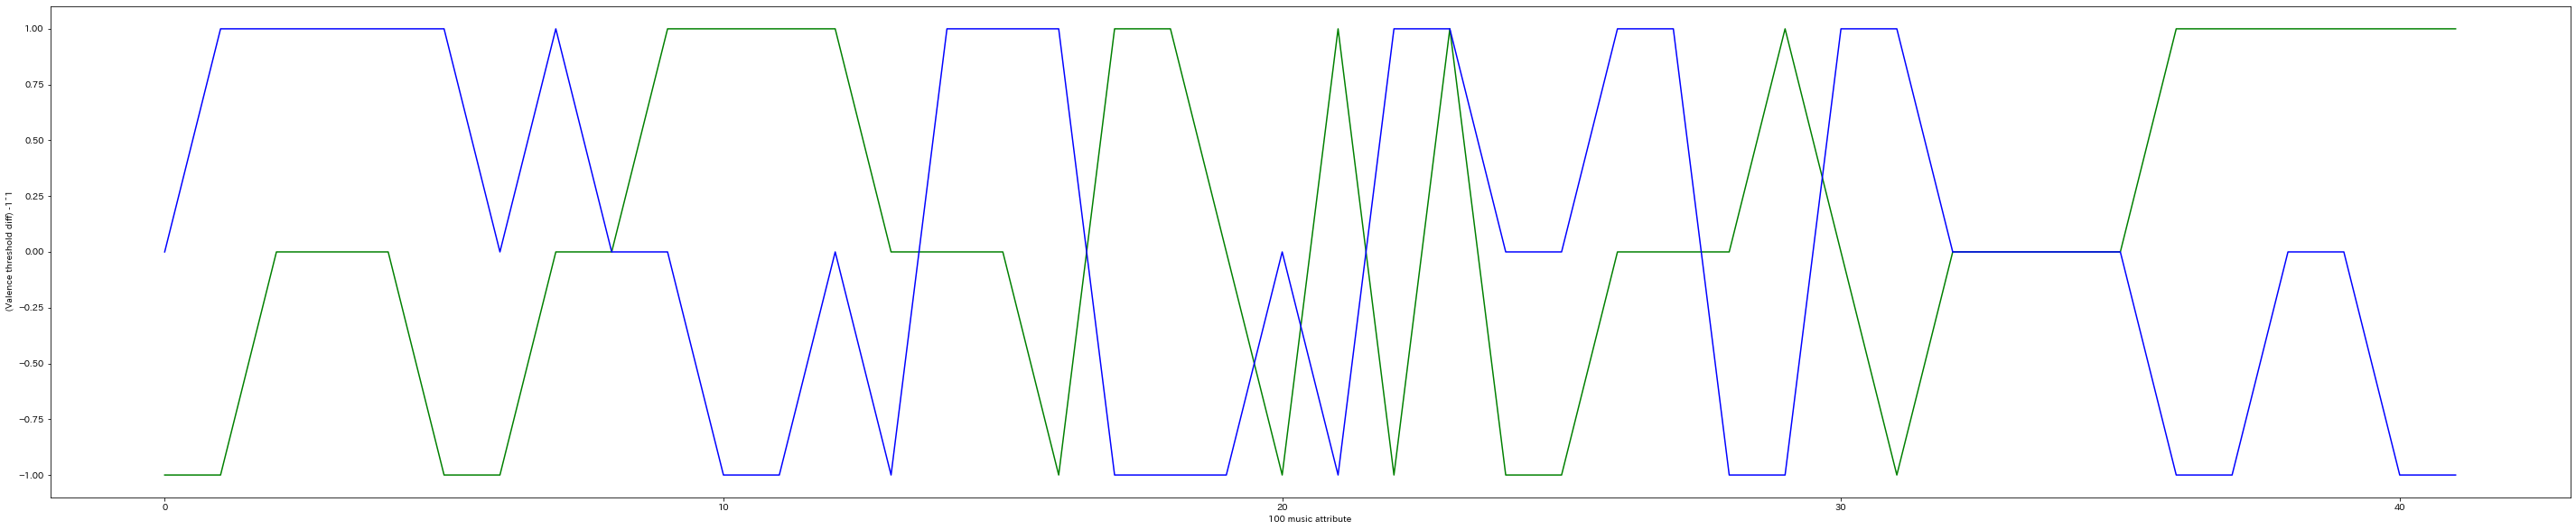

In [147]:
print('Q3 - Q2')      
print(Q1_4_diff((Q1_4average[2]-Q1_4average[1])[58:]))
print('\n')
print('Q1 - Q4') 
print(Q1_4_diff((Q1_4average[0]-Q1_4average[3])[58:]))

plt.figure(figsize=(50,10))
plt.plot((Q1_4average[2]-Q1_4average[1])[58:] ,color='green') # Q2 - Q1 (負の変化)  
plt.plot((Q1_4average[0]-Q1_4average[3])[58:] ,color='blue') # Q4 - Q3　(正の変化)
plt.xlabel('100 music attribute')
plt.ylabel(' (Valence threshold diff) -1~1')
plt.show()

### **Valence・Arousal**両方変化 
* 象限間の「0,1の差」をプロット   
Q4 - Q2 (「正・負」の変化)  
Q3 - Q1 (「負・負」の変化)

Q4 - Q2
[ 0  0  0  1  0  1  0  0  0  1 -1 -1  1  0  0  1  1  1  1  0  0  0  1  0
 -1  0  1  1  0  0  0  1  1  1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
 -1  1 -1 -1 -1  0  0  0  0 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  1  1  0
 -1 -1 -1  1  1  1 -1  1 -1  0 -1 -1 -1 -1  0  1 -1 -1  0  0  0  0  1  1
  1  1  1  1]
[3, 5, 9, 10, 11, 12, 15, 16, 17, 18, 22, 24, 26, 27, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 94, 95, 96, 97, 98, 99]


Q3 - Q1
[-1  1 -1 -1  0  0 -1  0  1  0 -1 -1  1 -1  0  0  0  1 -1  0  0  0 -1  0
  1  1  0  0  0  0  1 -1  0  1  0  0 -1 -1  0  0  0 -1 -1  0  0 -1 -1  0
  1 -1 -1 -1  1 -1  1  0  0  0  0 -1  0  0  0 -1 -1 -1 -1  0  1  1  0  1
  0  0 -1  1  1  0  0  1 -1  0  0  0  0  0  1  1  0 -1  0  0  0  0  1  1
  0  0  1  1]
[0, 1, 2, 3, 6, 8, 10, 11, 12, 13, 17, 18, 22, 24, 25, 30, 31, 33, 36, 37, 41, 42, 45, 46, 48, 49, 50, 5

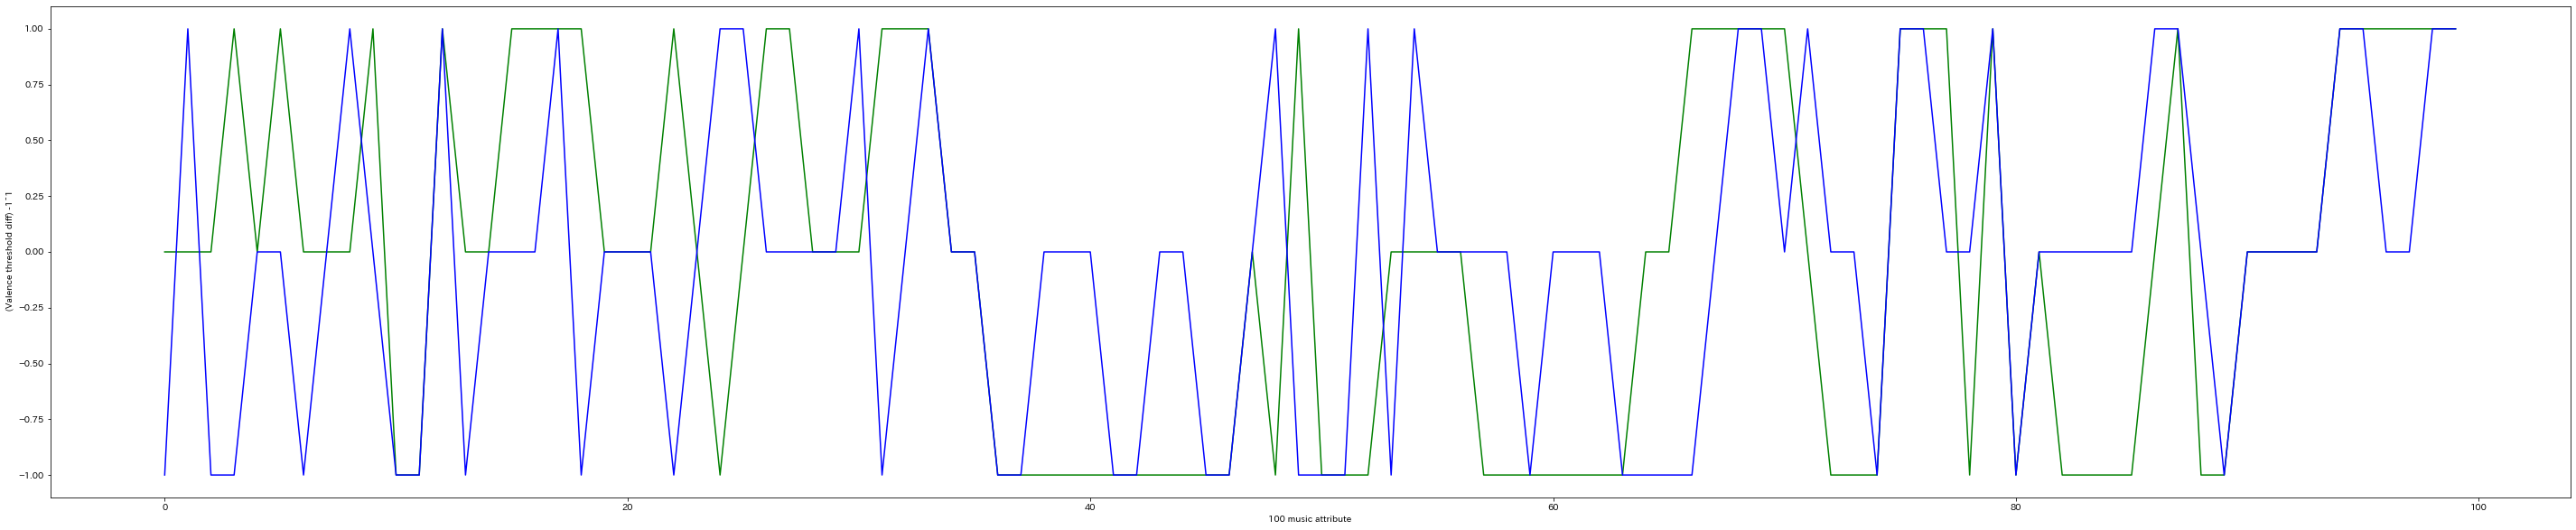

In [96]:
print('Q4 - Q2')      
print(Q1_4_diff(Q1_4average[3]-Q1_4average[1]))
print('\n')
print('Q3 - Q1') 
print(Q1_4_diff(Q1_4average[2]-Q1_4average[0]))

plt.figure(figsize=(50,10))
plt.plot(Q1_4average[3]-Q1_4average[1] ,color='green') # Q4 - Q2 (「正・負」の変化)
#sns.scatterplot(data = Q1_4average[3]-Q1_4average[1] , color="green")    
plt.plot(Q1_4average[2]-Q1_4average[0] ,color='blue') # Q3 - Q1 (「負・負」の変化)  
#sns.scatterplot(data = Q1_4average[2]-Q1_4average[0] , color="blue") 
plt.xlabel('100 music attribute')
plt.ylabel(' (Valence threshold diff) -1~1')
plt.show()

* 各象限ごとの0,1の値の分布も、同様にプロット

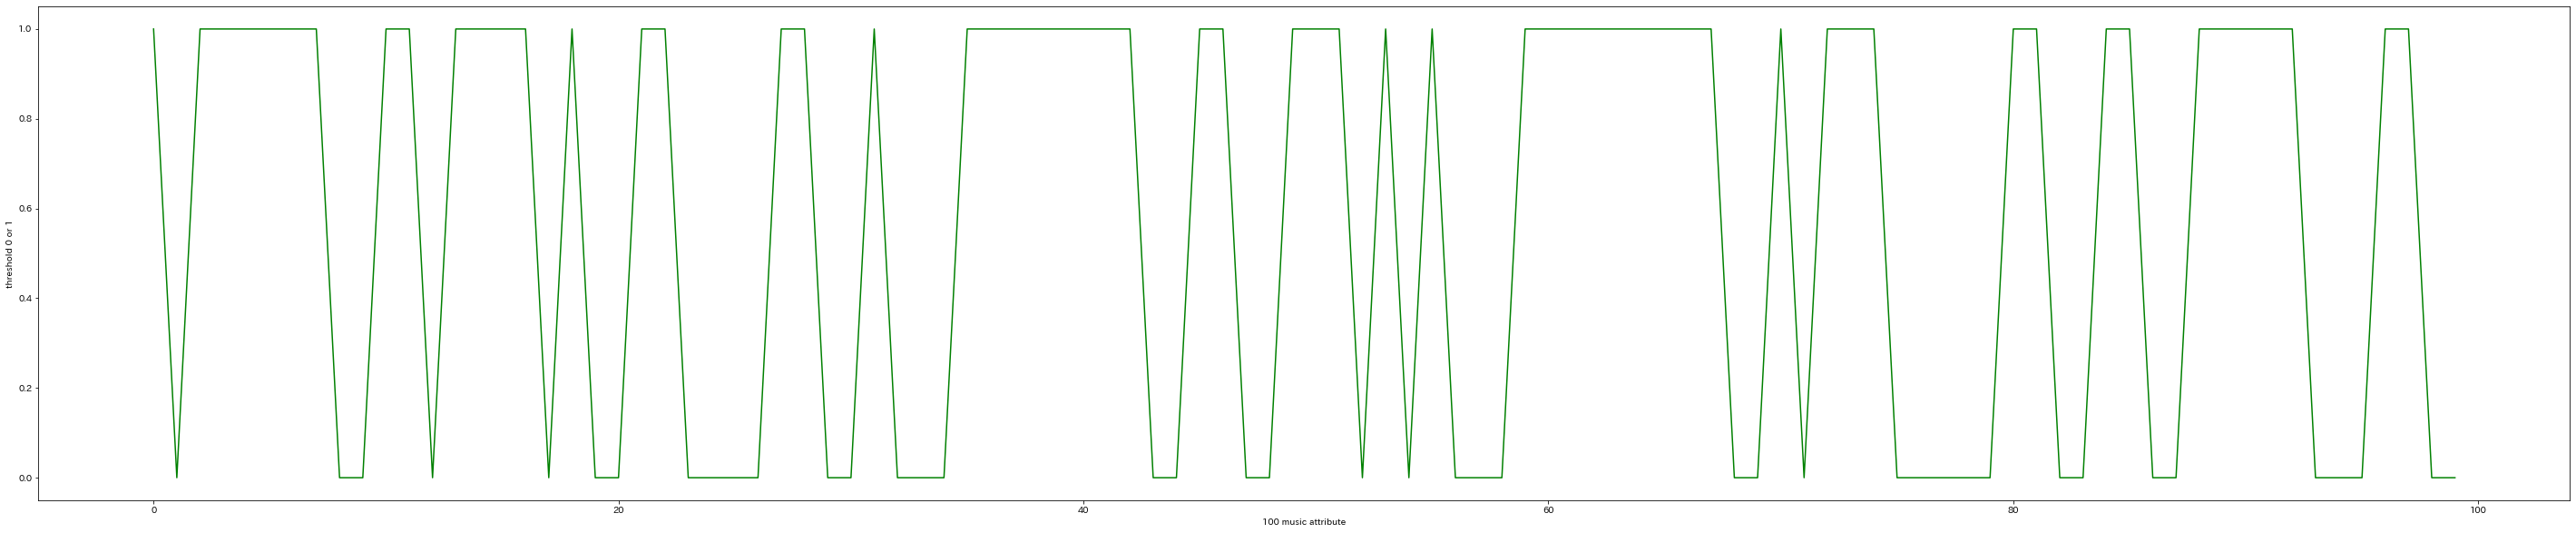

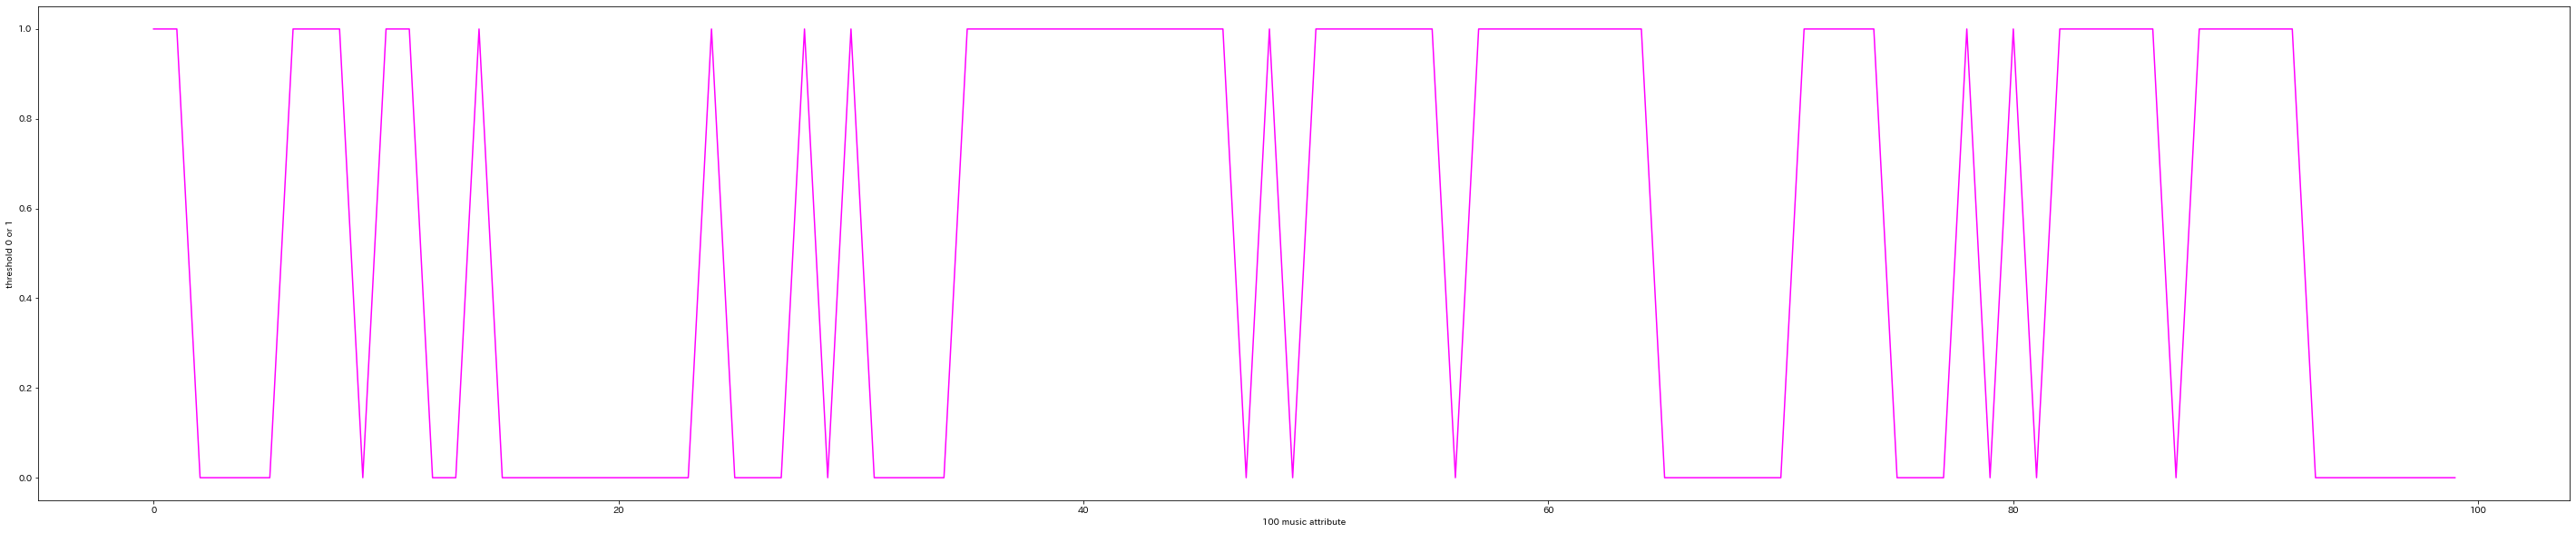

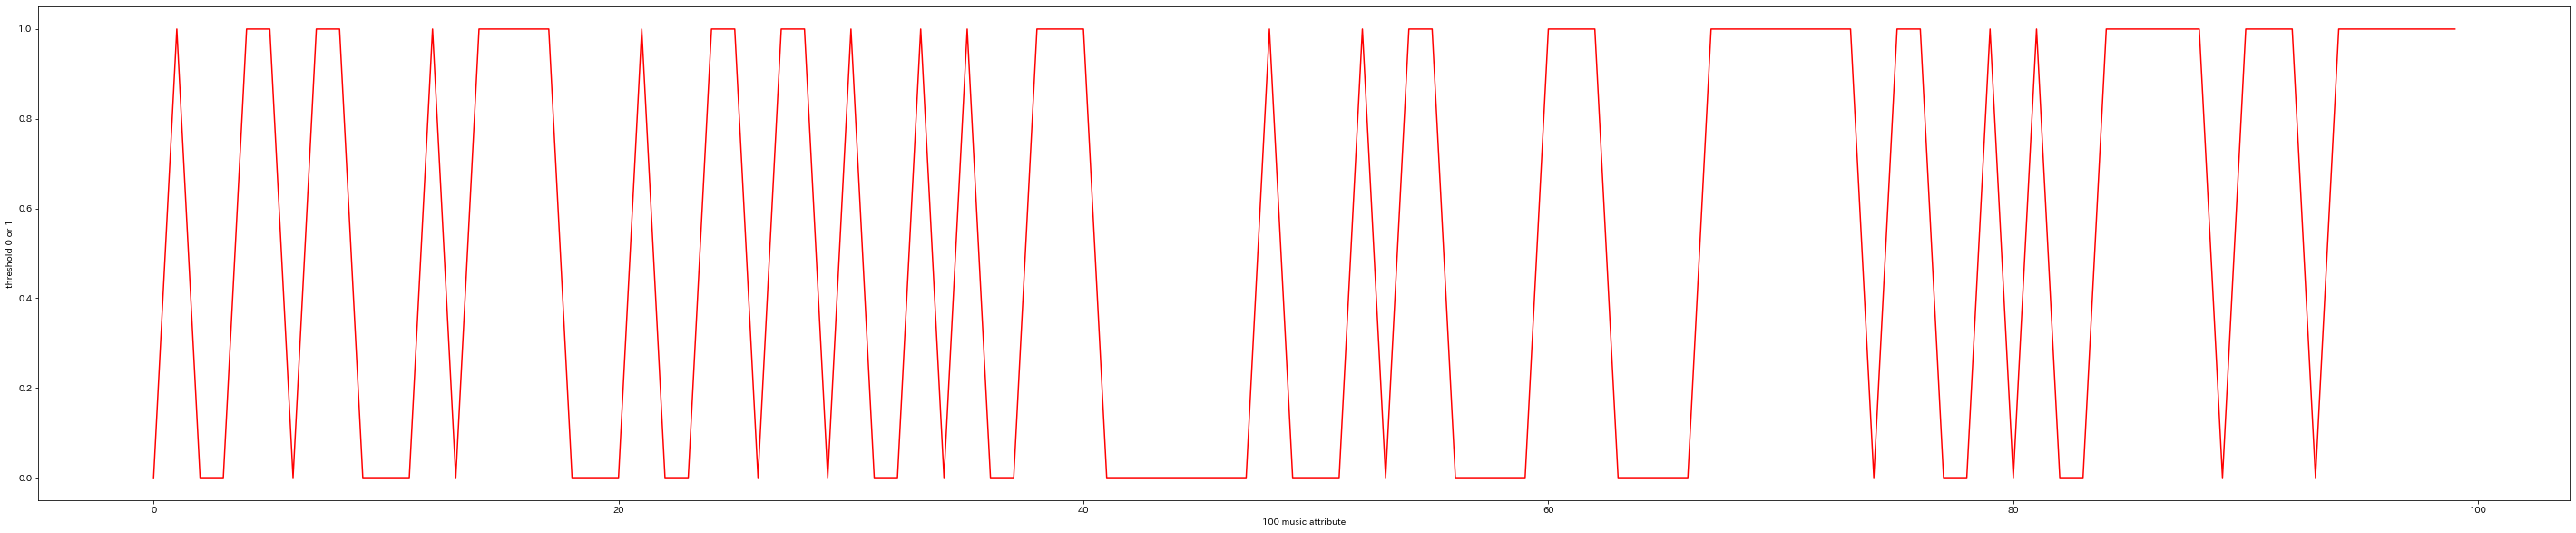

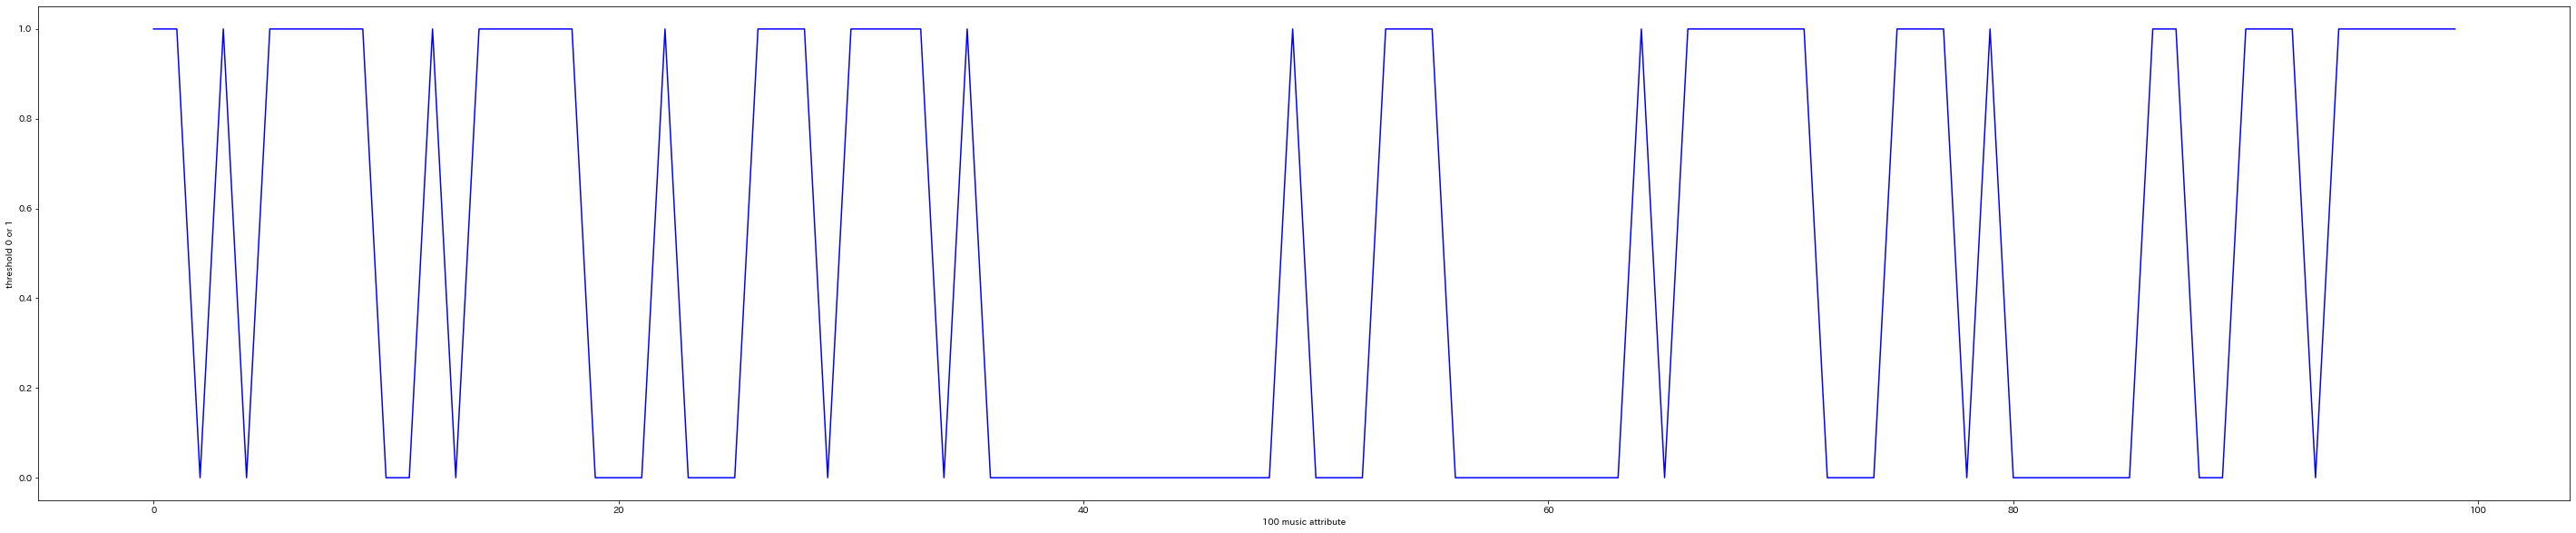

In [160]:
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import japanize_matplotlib
import numpy as np

#plt.figure(figsize=(50,10))
#plt.subplot(1,2,1)
#sc = StandardScaler() 

plt.figure(figsize=(50,10))
plt.plot(Q1_4average[0] , color="green") #sns.scatterplot(data = Q1_4average[0] , color="green")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()

plt.figure(figsize=(50,10))
plt.plot(Q1_4average[1] , color="magenta") #sns.scatterplot(data = Q1_4average[1] , color="magenta")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()

plt.figure(figsize=(50,10))
plt.plot(Q1_4average[2] , color="red") #sns.scatterplot(data = Q1_4average[2] , color="yellow")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()

plt.figure(figsize=(50,10))
plt.plot(Q1_4average[3] , color="blue") #sns.scatterplot(data = Q1_4average[3] , color="blue")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()